[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# Multivariate Kalman Filters

In [35]:
#format the book
%matplotlib inline
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function
from book_format import load_style, set_figsize, figsize
load_style()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction

The techniques in the last chapter are very powerful, but they only work in one dimension. The gaussians represent a mean and variance that are scalars - real numbers. They provide no way to represent multidimensional data, such as the position of a dog in a field. You may retort that you could use two Kalman filters from the last chapter. One would track the x coordinate and the other  the y coordinate. That does work, but put that thought aside, because soon you will see some enormous benefits to implementing the multidimensional case. Through one key insight we will achieve markedly better filter performance than was possible with the equations from the last chapter.

In this chapter I am purposefully glossing over many aspects of the mathematics behind Kalman filters. If you are familiar with the topic you will read statements that you disagree with because they contain simplifications that do not necessarily hold in more general cases. If you are not familiar with the topic, expect some paragraphs to be somewhat 'magical' - it will not be clear how I derived a certain result. I prefer that you develop an intuition for how these filters work through several worked examples. If I started by presenting a rigorous mathematical formulation you would be left scratching your head about what all these terms mean and how you might apply them to your problem. In later chapters I will provide a more rigorous mathematical foundation, and at that time I will have to either correct approximations that I made in this chapter or provide additional information that I did not cover here. 

To make this possible we will restrict ourselves to a subset of problems which we can describe with Newton's equations of motion. In the literature these filters are sometimes called 
**discretized continuous-time kinematic filters**. In the *Kalman Filter Math* chapter we will develop the math required for solving any kind of dynamic system. 


This subset consists of systems which can be described with Newton's equations of motion: given a constant velocity $v$ of a system we can compute its position $x$ after time $t$ with:

$$x = vt + x_0$$

For example, if we start at position 13 ($x_0=13$), our velocity is 10 m/s ($v=10$) and we travel for 12 seconds($t=12$) our final position is 133 ($133=10\times 12 + 13$).

We can incorporate constant accleration with this equation

$$x = \frac{1}{2}at^2 + v_0 t + x_0$$

And if we assume constant jerk we get

$$x = \frac{1}{6}jt^3 +  \frac{1}{2}a_0 t^2 + v_0 t + x_0$$

As a reminder, we can generate these equations using basic calculus. Given a constant velocity v we can compute the distance traveled over time with the equation

$$\begin{aligned} v &= \frac{dx}{dt}\\
dx &= v\, dt \\
\int_{x_0}^x\, dx &= \int_0^t v\, dt\\
x - x_0 &= vt - 0\\
x &= vt + x_0\end{aligned}$$

## Multivariate Normal Distributions

In the last two chapters we used Gaussians for a scalar (one dimensional) variable, expressed as $\mathcal{N}(\mu, \sigma^2)$. A more formal term for this is **univariate normal**, where univariate just means 'one variable'. The probability distribution of the Gaussian is also called the **univariate normal distribution**

What might a **multivariate normal distribution** be? In this context, multivariate just means multiple variables. Our goal is to be able to represent a normal distribution across multiple dimensions. Consider the 2 dimensional case. Let's say we believe that $x = 2$ and $y = 17$. This might be the *x* and *y* coordinates for the position of our dog, it might be the  position and velocity of our dog on the x-axis, or the temperature and wind speed at our weather station, it doesn't really matter. We can see that for $N$ dimensions, we need $N$ means, which we will arrange in a column matrix (vector) like so:

$$
\mu = \begin{bmatrix}{\mu}_1\\{\mu}_2\\ \vdots \\{\mu}_n\end{bmatrix}
$$

Therefore for this example we would have

$$
\mu = \begin{bmatrix}2\\17\end{bmatrix} 
$$

The next step is representing our variances. At first blush we might think we would also need N variances for N dimensions. We might want to say the variance for x is 10 and the variance for y is 4, like so. 

$$\sigma^2 = \begin{bmatrix}10\\4\end{bmatrix}$$ 

This is incorrect because it does not consider the more general case. For example, suppose we were tracking house prices vs total $m^2$ of the floor plan. These numbers are **correlated**. It is not an exact correlation, but in general houses in the same neighborhood are more expensive if they have a larger floor plan. We want a way to express not only what we think the variance is in the price and the $m^2$, but also the degree to which they are correlated. We use a **covariance matrix** to denote **covariances** with multivariate normal distributions. You might guess, correctly, that **covariance** is short for **correlated variances**.

$$
\Sigma = \begin{bmatrix}
  \sigma_1^2 & \sigma_{12} & \cdots & \sigma_{1n} \\
  \sigma_{21} &\sigma_2^2 & \cdots & \sigma_{2n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  \sigma_{n1} & \sigma_{n2} & \cdots & \sigma_n^2
 \end{bmatrix}
$$

If you haven't seen this before it is probably a bit confusing at the moment. Rather than explain the math right now, we will take our usual tactic of building our intuition first with various thought experiments. At this point, note that the diagonal contains the variance for each state variable, and that all off-diagonal elements (covariances) are represent how much the $i$th (row) and $j$th (column) state variable are linearly correlated to each other. In other words, it is a measure for how much they change together. A covariance of 0 indicates no correlation. So, for example, if the variance for x is 10, the variance for y is 4, and there is no linear correlation between x and y, then we would say

$$\Sigma = \begin{bmatrix}10&0\\0&4\end{bmatrix}$$

If there was a small amount of correlation between x and y we might have

$$\Sigma = \begin{bmatrix}10&1.2\\1.2&4\end{bmatrix}$$

where 1.2 is the covariance between x and y. Note that this is always symmetric - the covariance between x and y is always equal to the covariance between y and x. That is, $\sigma_{xy}=\sigma_{yx}$ for any x and y.

Now, without explanation, here is the full equation for the multivariate normal distribution in $n$ dimensions.

$$\mathcal{N}(\mu,\,\Sigma) = (2\pi)^{-\frac{n}{2}}|\Sigma|^{-\frac{1}{2}}\, e^{ -\frac{1}{2}(\mathbf{x}-\mu)^\mathsf{T}\Sigma^{-1}(\mathbf{x}-\mu) }$$

I urge you to not try to remember this function. We will program it in a Python function and then call it if we need to compute a specific value. Plus, it turns out that the Kalman filter equations will compute this for us automatically; we never have to compute it ourselves. However, if you look at it briefly you will note that it looks quite similar to the univariate normal distribution  except it uses matrices instead of scalar values, and the root of $\pi$ is scaled by $n$. Here is the univariate equation for reference:

$$ 
f(x, \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}} e^{{-\frac{1}{2}}{(x-\mu)^2}/\sigma^2 }
$$

The multivariate version merely replaces the scalars of the univariate equations with matrices. If you are reasonably well-versed in linear algebra this equation should look quite manageable; if not, don't worry! Let's just plot it and see what it looks like.

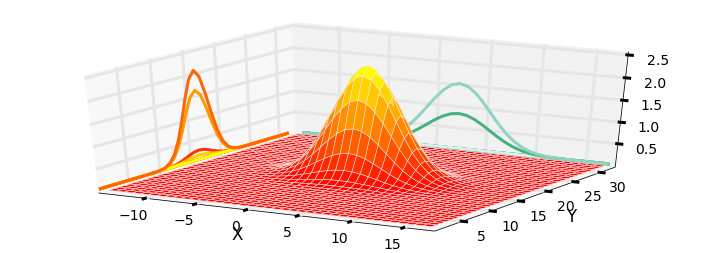

In [36]:
import mkf_internal
mkf_internal.plot_3d_covariance((2, 17), [[10., 10], [10, 4.]])

Here we have plotted a two dimensional multivariate Gaussian with a mean of $\mu=[\begin{smallmatrix}2\\17\end{smallmatrix}]$ and a covariance of $\Sigma=[\begin{smallmatrix}10&0\\0&4\end{smallmatrix}]$. The three dimensional shape shows the probability of for any value of (x,y) in the z-axis. I have projected just the variance for x and y onto the walls of the chart - you can see that they take on the normal Gaussian bell curve shape. You can also see that, as we might hope, that the curve for x is wider than the curve for y, which is explained by $\sigma_x^2=10$ and $\sigma_y^2=4$. Also, the highest point of the curve is centered over (2,17), the means for x and y. I hope this demystifies the equation for you. Any multivariate Gaussian will create this sort of shape. If we think of this as a the Gaussian for our dog's position in a two dimensional field, the z-value at each point of (x,y) is the probability density for the dog being at that position. So, he has the highest probability of being near (2,17), a modest probability of being near (5,14), and a very low probability of being near (10,10).

We will discuss the mathematical description of covariances in the Kalman Filter math chapter. For this chapter we just need to understand the following.

1. The diagonal of the matrix contains the variance for each variable. 

2. Each off-diagonal element contains $\sigma_{ij}$ - the covariance between *i* and *j*. This tells us how much linear correlation there is between the two variables. 0 means no correlation, and as the number gets higher the correlation gets greater.

3. $\sigma_{ij} = \sigma_{ji}$: if i gets larger when j gets larger, then it must be true that j gets larger when i gets larger.

4. The covariance between x and itself is just the variance of x: $\sigma_{xx} = \sigma_x^2$.

5. This chart only shows a 2 dimensional Gaussian, but the equation works for any number of dimensions > 0. It's *kind of* hard to show a chart for the higher dimensions, so we will have to be satisfied with 2 dimensions.

I have programmed the multivariate Gaussian equation into my FilterPy library with the function name `multivariate_gaussian`. I am not showing the code here because I have taken advantage of the linear algebra solving apparatus of NumPy to efficiently compute a solution - the code does not correspond to the equation in a one to one manner. If you wish to view the code, I urge you to load it in an editor. 

However, please note that the Kalman filter equations incorporate this computation automatically; you will not be using this function very often in this book, so I would not spend a lot of time mastering this function unless it interests you.

>As of version 0.14 scipy.stats has implemented the multivariate normal equation with the function `multivariate_normal()`. It implements a 'frozen' form where you set the mean and covariance once, and then calculate the probability for any number of values for x over any arbitrary number of calls. This is much more efficient then recomputing everything in each call. So, if you have version 0.14 or later you may want to substitute my function for the built in version. Use `scipy.version.version` to get the version number. I deliberately named my function `multivariate_gaussian()` to ensure it is never confused with the built in version. I will say that for a single call, where the frozen variables do not matter, mine consistently runs faster as measured by the `timeit` function.

> The <a href="http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html">tutorial</a>[1] for the `scipy.stats` module explains 'freezing' distributions and other very useful features. As of this date, it includes an example of using the multivariate_normal function, which does work a bit differently from my function.

In [12]:
from filterpy.common import gaussian, multivariate_gaussian

Let's use it to compute a few values just to make sure we know how to call and use the function, and then move on to more interesting things.

First, let's find the probability density for our dog being at (2.5, 7.3) if we believe he is at (2, 7) with a variance of 8 for $x$ and a variance of 4 for $y$.

Start by setting $x$ to (2.5, 7.3):

In [13]:
x = [2.5, 7.3]

Next, we set the mean of our belief:

In [37]:
mu = [2.0, 7.0]

Finally, we have to define our covariance matrix. In the problem statement we did not mention any correlation between $x$ and $y$, and we will assume there is none. This makes sense; a dog can choose to independently wander in either the $x$ direction or $y$ direction without affecting the other. If there is no correlation between the values you just fill in the diagonal of the covariance matrix with the variances. I will use the seemingly arbitrary name $\textbf{P}$ for the covariance matrix. The Kalman filters use the name $\textbf{P}$ for this matrix, so I will introduce the terminology now to avoid explaining why I change the name later. 

In [15]:
P = [[8., 0.], [0., 4.]]

Now just call the function

In [16]:
print('{:.4}'.format(multivariate_gaussian(x, mu, P)))

0.02739


> Note that the function can accept lists, np.array, or np.matrix as arguments, or even scalars. Type `multivariate_gaussian?` in a cell and press CTRL-enter to get the help for this function. 

These numbers are not easy to interpret. Let's plot this in 3D, with the $z$ (up) coordinate being the probability distribution.

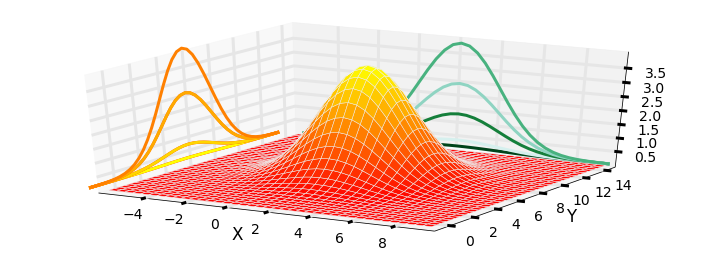

In [38]:
import mkf_internal
mkf_internal.plot_3d_covariance(mu, P)

The result is clearly a 3D bell shaped curve. We can see that the Gaussian is centered around (2,7), and that the probability density quickly drops away in all directions. On the sides of the plot I have drawn the Gaussians for $x$ in greens and for $y$ in orange.

Let's look at this in a slightly different way. Instead of plotting a surface showing the probability distribution I will just generate 1,000 points with the distribution of $[\begin{smallmatrix}8&0\\0&4\end{smallmatrix}]$.

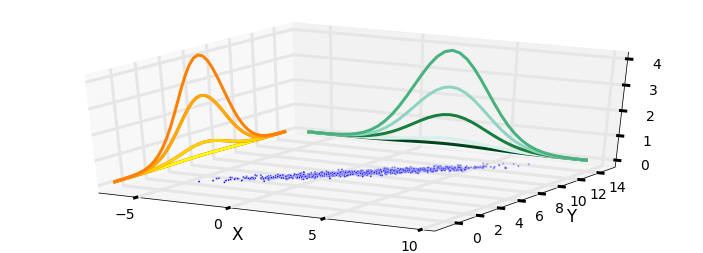

In [39]:
mkf_internal.plot_3d_sampled_covariance(mu, P)

We can think of the sampled points as being possible locations for our dog given those particular mean and covariances. The contours on the side show the variance in the points for $x$ and $y$ only. We can see that he is far more likely to be at (2, 7) where there are many points, than at (-5, 0) where there are few.

As beautiful as this is, it is perhaps a bit hard to get useful information. For example, it is not easy to tell if $x$ and $y$ both have the same variance or not. So for most of the rest of this book we will display multidimensional Gaussian using contour plots. I will use some helper functions in FilterPy to plot them. If you are interested in linear algebra go ahead and look at the code used to produce these contours, otherwise feel free to ignore it. 

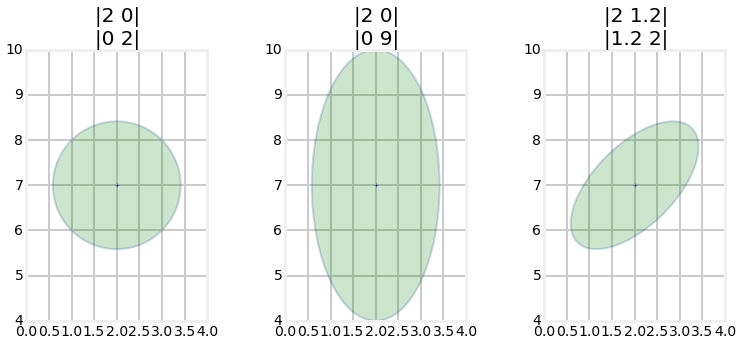

In [40]:
with figsize(y=5):
    mkf_internal.plot_3_covariances()

And for those of you viewing this online or in IPython Notebook on your computer, here is an animation.
<img src='animations/multivariate_ellipse.gif'>

From a mathematical perspective these display the values that the multivariate Gaussian takes for a specific standard deviation. This is like taking a horizontal slice out of the 3D plot. By default it displays one standard deviation, but you can use the `variance` parameter to control what is displayed. For example, `variance=3**2` would display the 3rd standard deviation, and `variance=[1,4,9]` would display the 1st, 2nd, and 3rd standard deviations as in the chart below. This takes 3 different horizontal slices of the multivariate Gaussian chart and displays them in 2D.

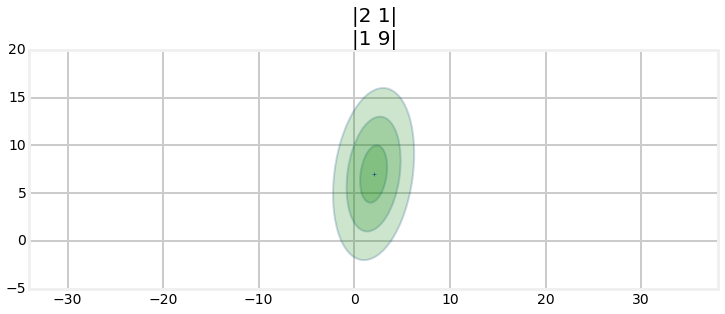

In [45]:
from filterpy.common import plot_covariance_ellipse
P = [[2, 1], [1, 9]]
plot_covariance_ellipse((2, 7), P, facecolor='g', alpha=0.2, 
                        variance=[1, 2**2, 3**2],
                        axis_equal=True, title='|2 1|\n|1 9|')

However, the solid colors may suggest that the probability distribution is constant between the standard deviations. This is not true, as you can tell from the 3D plot of the Gaussian. Here is a 2D shaded representation of the probability distribution for the covariance ($\begin{smallmatrix}2&1.2\\1.2&1.3\end{smallmatrix})$.

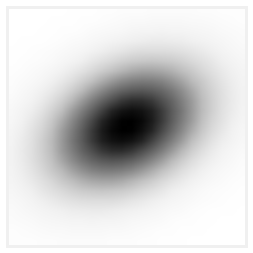

In [49]:
from nonlinear_plots import plot_cov_ellipse_colormap
plot_cov_ellipse_colormap(cov=[[2, 0.5], [0.5, 1.3]])

Thinking about the physical interpretation of these plots clarifies their meaning. The first plot uses the mean and covariance matrices of

$$
\mathbf{\mu} =\begin{bmatrix}2\\7\end{bmatrix},\, \,
\Sigma = \begin{bmatrix}2&0\\0&2\end{bmatrix}
$$ 

Let this be our current belief about the position of our dog in a field. In other words, we believe that he is positioned at (2,7) with a variance of $\sigma^2=2$ for both x and y. The contour plot shows where we believe the dog is located with the '+' in the center of the ellipse. The ellipse shows the boundary for the $1\sigma$ probability, where $1\sigma$ is one **standard deviation**. In other words, for this Gaussian 68% of the data will fall within this ellipse. Recall from the Gaussians chapter the the 68-95-99.7 rule - 68% of all values will fall within 1 standard deviation ($1\sigma$), 95% within $2\sigma$, and 99.7% within $3\sigma$. The dog could be at (356443,58483), but the chances for values that far away from the mean are infinitesimally small.

An equivalent way of thinking about this is the circle/ellipse shows us the amount of error in our belief. A tiny circle would indicate that we have a very small error, and a very large circle indicates a lot of error in our belief. We will use this throughout the rest of the book to display and evaluate the accuracy of our filters at any point in time. 

The second plot uses the mean and covariance matrices of

$$
\mu =\begin{bmatrix}2\\7\end{bmatrix}, \, \, \, 
\Sigma = \begin{bmatrix}2&0\\0&9\end{bmatrix}
$$

This time we use a different variance for $x$ (2) vs $y$ (9). The result is an ellipse. When we look at it we can immediately tell that we have a lot more uncertainty in the $y$ value vs the $x$ value. Our belief that the value is (2, 7) is the same in both cases, but errors are different. In this case the standard deviation in $x$ is $\sigma_x = \sqrt{2}=1.414$ and the standard deviation for $y$ is $\sigma_y = \sqrt{9}=3$. This sort of thing happens naturally as we track objects in the world - one sensor has a better view of the object, or is closer, than another sensor, and so we end up with different error rates in the different axis.


The third plot uses the mean and covariance matrices of:

$$
\mu =\begin{bmatrix}2\\7\end{bmatrix}, \, \, \, 
\Sigma = \begin{bmatrix}2&1.2\\1.2&2\end{bmatrix}
$$

This is the first contour that has values in the off-diagonal elements of $cov$, and this is the first contour plot with a slanted ellipse. This is not a coincidence. The two facts are telling use the same thing. A slanted ellipse tells us that the $x$ and $y$ values are somehow **correlated**. We denote that in the covariance matrix with values off the diagonal. What does this mean in physical terms? Think of trying to park your car in a parking spot. You can not pull up beside the spot and then move sideways into the space because cars cannot drive sideways. $x$ and $y$ are not independent. This is a consequence of the steering system in a car. When your tires are turned the car rotates around its rear axle while moving forward. Or think of a horse attached to a pivoting exercise bar in a corral. The horse can only walk in circles, he cannot vary $x$ and $y$ independently, which means he cannot walk in a straight line. If $x$ changes, $y$ must also change in a defined way. 

So when we see this ellipse we know that $x$ and $y$ are correlated, and that the correlation is "strong". The size of the ellipse shows how much error we have in each axis, and the slant shows how the relative sizes of the variance in $x$ and $y$. For example, a very long and narrow ellipse tilted almost to the horizontal has a strong correlation between $x$ and $y$ (because the ellipse is narrow), and the variance of $x$ is much larger than that of $y$ (because the ellipse is much longer in $x$).

## Using Correlations to Improve Estimates

Let's look at this in a graph and then reason about it. Let's assume that we have a covariance for the position of our dog, and we believe he is at the coordinate (5, 10) meters. If the standard deviation in x and y is each 2 meters, but they are strongly correlated, our covariance contour would look like this.

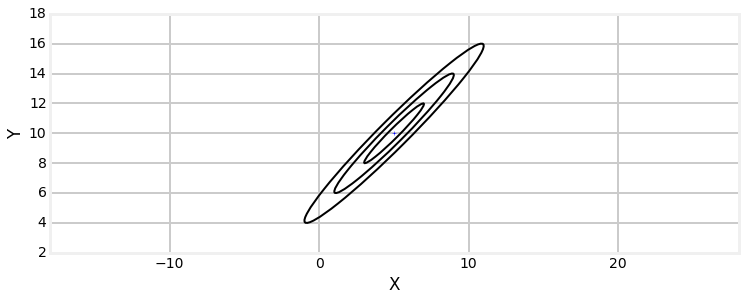

In [50]:
import matplotlib.pyplot as plt

P = [[4, 3.9], [3.9, 4]]
plot_covariance_ellipse((5, 10), P, edgecolor='k', 
                        variance=[1, 2**2, 3**2])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


Now suppose I were to tell you that the actual position of the dog in the x-axis is 7.5, what can we infer about his position in the y-axis? The position is extremely likely to lie within the 3$\sigma$ covariance ellipse, as in the chart below. We can *infer* the like position in *y* based on the covariance matrix because there is a correlation between *x* and *y*.

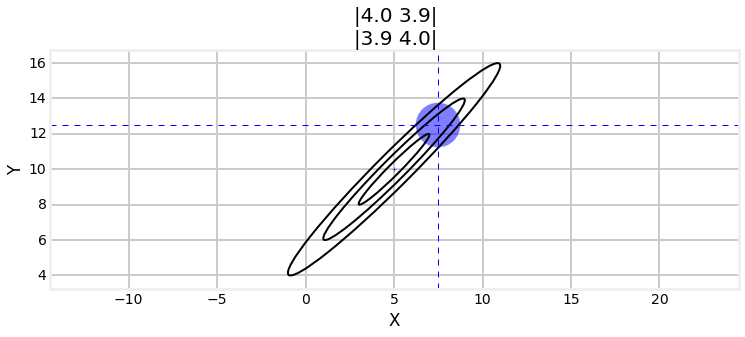

In [14]:
mkf_internal.plot_correlation_covariance()

A word about **correlation** and **independence**. If variables are **independent** they can vary separately. If you walk in an open field, you can move in the $x$ direction (east-west), the $y$ direction(north-south), or any combination thereof. Independent variables are always also **uncorrelated**. Except in special cases, the reverse does not hold true. Variables can be uncorrelated, but dependent. For example, consider the pair$(x,y)$ where $y=x^2$. Correlation is a linear measurement, so $x$ and $y$ are uncorrelated. However, they are obviously dependent on each other. 

## Multiplying Multidimensional Gaussians

In the previous chapter we incorporated an uncertain measurement with an uncertain estimate by multiplying their Gaussians together. The result was another Gaussian with a smaller variance. If two pieces of uncertain information corroborate each other we should be more certain in our conclusion. The graphs look like this:

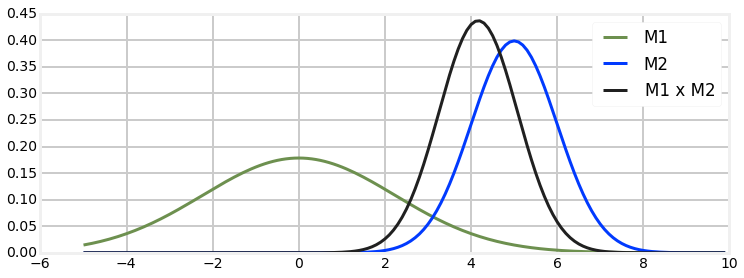

In [15]:
mkf_internal.plot_gaussian_multiply()

The combination of measurement 1 and 2 yields more certainty, so the new Gaussian is taller and narrower - the variance became smaller. The same thing happens in multiple dimensions with multivariate Gaussians.

Here are the equations for multiplying multivariate Gaussians. You will not need to remember these equations, as they are computed by Kalman filter equations that will be presented shortly. This computation is also available in FilterPy using the `multivariate_multiply()` method, which you can import from `filterpy.common`. 

$$\begin{aligned}
\mu &= \Sigma_2(\Sigma_1 + \Sigma_2)^{-1}\mu_1 + \Sigma_1(\Sigma_1 + \Sigma_2)^{-1}\mu_2 \\
\Sigma &= \Sigma_1(\Sigma_1+\Sigma_2)^{-1}\Sigma_2
\end{aligned}$$

To give you some intuition about this, recall the equations for multiplying univariate Gaussians:

$$\begin{aligned}
\mu &=\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{1}{\frac{1}{\sigma_1^2} + \frac{1}{\sigma_2^2}} = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}
\end{aligned}$$

This looks similar to the equations for the multivariate equations. This will be more obvious if you recognize that matrix inversion, denoted by the -1 power, is *like* division since $AA^{-1} =I$. I will rewrite the inversions as divisions - this is not a mathematically correct thing to do but it does help us see what is going on.

$$\begin{aligned}
\mu &\approx \frac{\Sigma_2\mu_1 + \Sigma_1\mu_2}{\Sigma_1 + \Sigma_2} \\ \\
\Sigma &\approx \frac{\Sigma_1\Sigma_2}{(\Sigma_1+\Sigma_2)}
\end{aligned}$$

In this form we can surmise that these equations are just the linear algebra form of the univariate equations.

Now let's explore multivariate Gaussians in terms of a concrete example. Suppose that we are tracking an aircraft with two radar systems. I will ignore altitude as this is easier to graph in two dimensions. Radars give us the range and bearing to a target. We start out being uncertain about the position of the aircraft, so the covariance, which is just our uncertainty about the position, might look like this. 

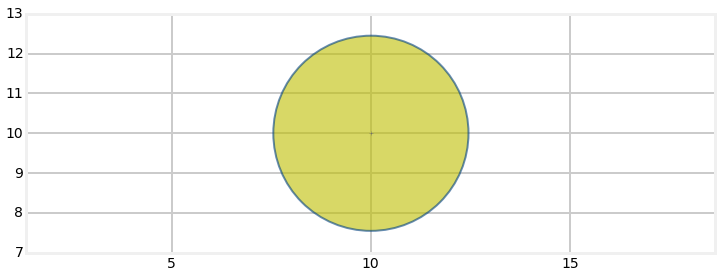

In [16]:
P0 = [[6, 0], [0, 6]]
plot_covariance_ellipse((10, 10), P0, facecolor='y', alpha=0.6)

Now suppose that there is a radar to the lower left of the aircraft. Further suppose that the radar is very accurate in the bearing measurement, but not very accurate at the range. That covariance, which is just the uncertainty in the reading might look like this (plotted in blue):

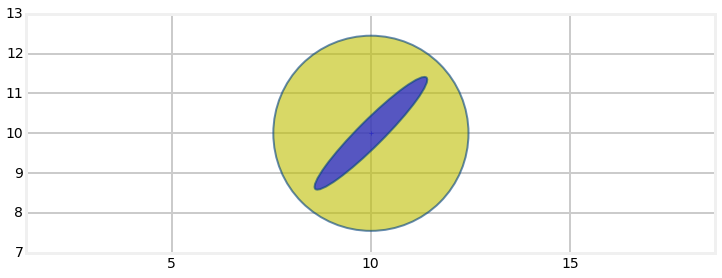

In [17]:
P1 = [[2, 1.9], [1.9, 2]]
plot_covariance_ellipse((10, 10), P0, facecolor='y', alpha=0.6)
plot_covariance_ellipse((10, 10), P1, facecolor='b', alpha=0.6)

To combine the information we multiply the two Gaussians together. I will use FilterPy's `multivariate_multiply` method to perform the multiplication.

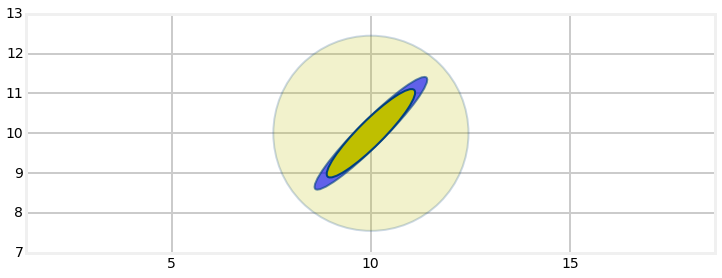

In [18]:
from filterpy.common import multivariate_multiply

P2 = multivariate_multiply((10, 10), P0, (10, 10), P1)[1]
plot_covariance_ellipse((10, 10), P0, facecolor='y', alpha=0.2)
plot_covariance_ellipse((10, 10), P1, facecolor='b', alpha=0.6)
plot_covariance_ellipse((10, 10), P2, facecolor='y')

Here I have plotted the original estimate it a very transparent yellow, the radar reading in blue, and the estimate generate by multiplying the two Gaussians together in yellow.

The Gaussian retained the same shape and position as the radar measurement, but is smaller. We've seen this with the one dimensional Gaussians. Multiplying two Gaussians makes the variance smaller because we are incorporating more information, hence we are less uncertain.  But the main point I want to make is that the covariance shape reflects the physical layout of the aircraft and the radar system.

Now lets say we get a measurement from a second radar bank, this one to the lower right, which I will plot in blue against the yellow covariance of our current belief. 

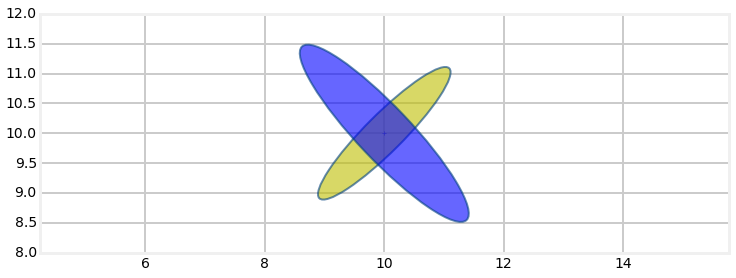

In [19]:
P3 = [[2, -1.9], [-1.9, 2.2]]
plot_covariance_ellipse((10, 10), P2, facecolor='y', alpha=0.6)
plot_covariance_ellipse((10, 10), P3, facecolor='b', alpha=0.6)

Again, to incorporate this new information we will multiply the Gaussians together.

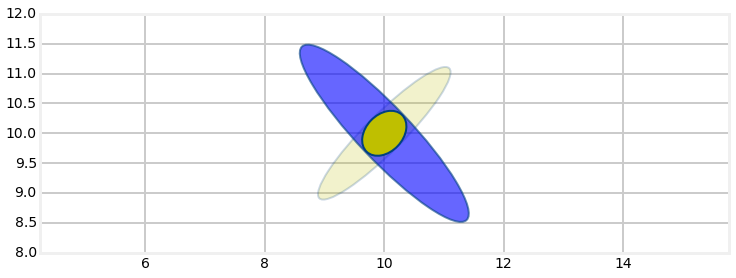

In [20]:
P4 = multivariate_multiply((10, 10), P2, (10, 10), P3)[1]
plot_covariance_ellipse((10, 10), P2, facecolor='y', alpha=0.2)
plot_covariance_ellipse((10, 10), P3, facecolor='b', alpha=0.6)
plot_covariance_ellipse((10, 10), P4, facecolor='y')

You can see how the multivariate Gaussian's shape reflects the geometry of the problem. The first radar system was at a 45 degree angle to the aircraft, and its error in the bearing measurement was much smaller than the error in the range. This resulted in a long and narrow covariance ellipse whose major axis was aligned with the angle to the radar system. The next radar system was also at a 45 degree angle, but to the right, so the two measurements were orthogonal to each other. This allowed us to *triangulate* on the aircraft, which resulted in a very accurate final estimate. We didn't explicitly write any code to perform triangulation; it was a natural outcome of multiplying the Gaussians of each measurement together.

To make sure you understand this, what would the Gaussian look like if we only had one radar station, and we receive several measurements from it over a short period of time? Clearly the Gaussian would remain elongated in the axis of the bearing angle. Without a second radar station no information would be provided to reduce the error on that axis, so it would remain quite large. As the aircraft moves the bearing will typically change by a small amount, so over time some of the error will be reduced, but it will never be reduced as much as a second radar station would provide.

To round this out lets quickly redo this example but with the first radar system in a different position. I will position it directly to the left of the aircraft. The only change I need to make is to the Gaussian for the measurement from the radar. In the previsous example I used

$$\Sigma = \begin{bmatrix}2&1.9\\1.9&2\end{bmatrix}$$

Why did this result in a 45 degree ellipse? Think about that before reading on. It was 45 degrees because the values in the diagonal were identical. So if x=10 then y=10, and so on. We can alter the angle by making the variance for x or y different, like so:

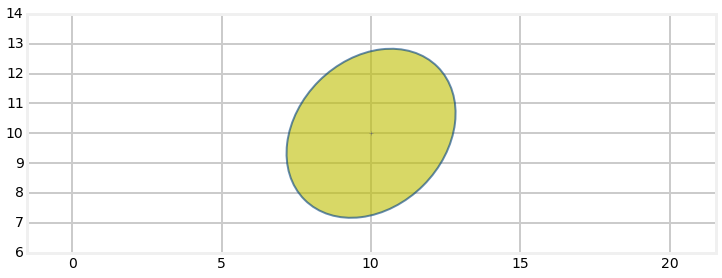

In [57]:
P1 = [[8, 1.9], [1.9, 8]]
plot_covariance_ellipse((10, 10), P1, facecolor='y', alpha=0.6)

The radar is to the left of the aircraft, so I can use a covariance of 

$$\Sigma = \begin{bmatrix}2&1.9\\1.9&2\end{bmatrix}$$

to model the measurement. In the next graph I plot the original estimate in a very light yellow, the radar measurement in blue, and the new estimate based on multiplying the two Gaussians together in yellow.

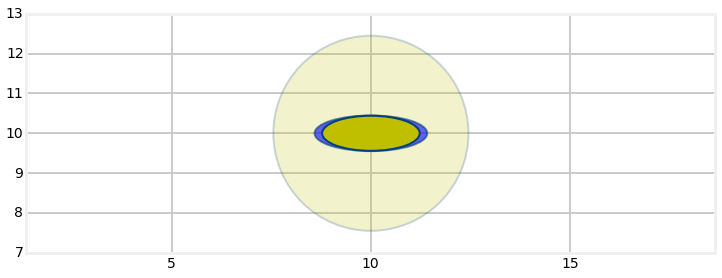

In [22]:
P1 = [[2, 0], [0, .2]]
P2 = multivariate_multiply((10, 10), P0, (10, 10), P1)[1]
plot_covariance_ellipse((10, 10), P0, facecolor='y', alpha=0.2)
plot_covariance_ellipse((10, 10), P1, facecolor='b', alpha=0.6)
plot_covariance_ellipse((10, 10), P2, facecolor='y')

Now we can incorporate the measurement from the second radar system, which we will leave in the same position as before.

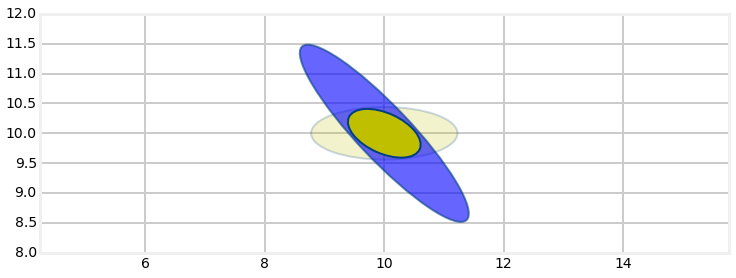

In [23]:
P3 = [[2, -1.9], [-1.9, 2.2]]
P4 = multivariate_multiply((10, 10), P2, (10, 10), P3)[1]
plot_covariance_ellipse((10, 10), P2, facecolor='y', alpha=0.2)
plot_covariance_ellipse((10, 10), P3, facecolor='b', alpha=0.6)
plot_covariance_ellipse((10, 10), P4, facecolor='y')

In this result our final estimate is not as accurate as the previous example. Why is that? The two radar stations were no longer othogonal to each other relative to the aircraft's position so the triangulation is not optimal. Imagine standing on the ground and trying to triangulate on an aircraft in the sky with a transit. If you took a measurement, moved the transit 5 meters and took a second measurement the tiny change in angle between the two measurements would result in a very poor measurement because a very small error in either measurement would give a wildly different result. Think of the measurements as two nearly parallel lines. Changing the angle between them slightly will move the intersection between the two by a large amount. If you were to take the measurements from positions 100 km apart the lines might be nearly perpendicular to each other, in which case a small measurement error would result in a very small shift in the intersection point.

## Unobserved Variables

You can probably already see why a multivariate Kalman filter can perform better than the univariate version in the last chapter. The last section demonstrated how we can use correlations between variables to significantly improve our estimates. But we can take this much further. This section contains the key insight to this chapter, so read carefully.

Let's say we are tracking an aircraft and we get the following data for the $x$ and $y$ coordinates at time $t$=1,2, and 3 seconds. What does your intuition tell you the value of $x$ will be at time $t$=4 seconds?

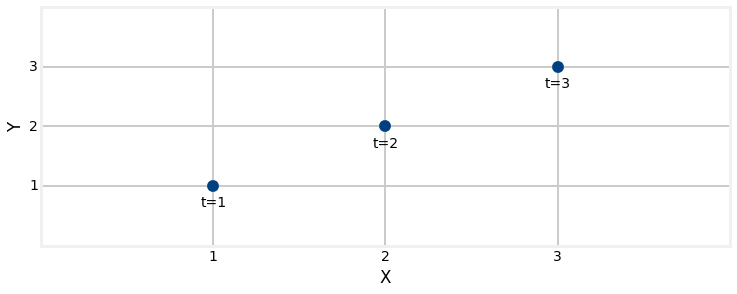

In [24]:
import mkf_internal
mkf_internal.show_position_chart()

It appears that the aircraft is flying in a straight line because we can draw a line between the three points, and we know that aircraft cannot turn on a dime. The most reasonable guess is that at $t$=4 the aircraft is at (4,4). I will depict that with a green arrow.

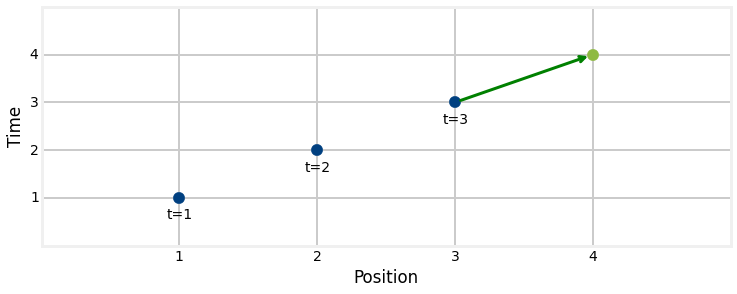

In [25]:
mkf_internal.show_position_prediction_chart()

You made this inference because you *inferred* a constant velocity for the airplane. The *reasonable* assumption is that the aircraft is moving one unit each in *x* and *y* per time step.

Think back to the g-h filter chapter when we were trying to improve the weight predictions of a noisy scale. We incorporated *weight gain* into the equations because it allowed us to make a better prediction of the weight the next day. The g-h filter uses the *g* parameter to scale the amount of significance given to the current weight measurement, and the *h* parameter scaled the amount of significance given to the weight gain.

We are going to do the same thing with our Kalman filter. After all, the Kalman filter is a form of a g-h filter. In this case we are tracking an airplane, so instead of weight and weight gain we need to track position and velocity. Weight gain is the *derivative* of weight, and of course velocity is the derivative of position. It's impossible to plot and understand the 4D chart that would be needed to plot *x* and *y* and their respective velocities so let's just do it for $x$, knowing that the math extends to multiple dimensions.

So at time 1 we might be fairly certain about the position (x=0) but have no idea about the velocity. We can plot that with a covariance matrix like this. The narrow width expresses our relative certainty about position, and the tall height expresses our lack of knowledge about velocity.

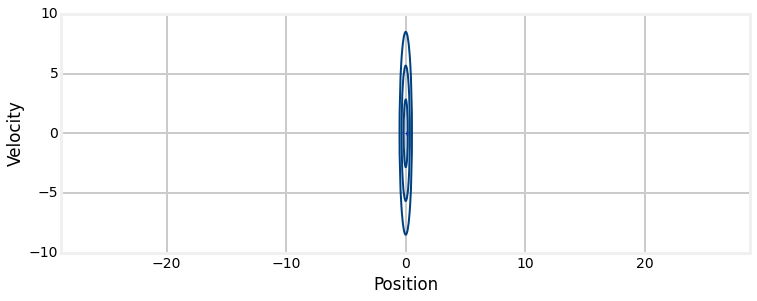

In [26]:
mkf_internal.show_x_error_chart(1)

Now after one second we get a position update of x=5. This implies that our velocity is roughly 5 m/s.

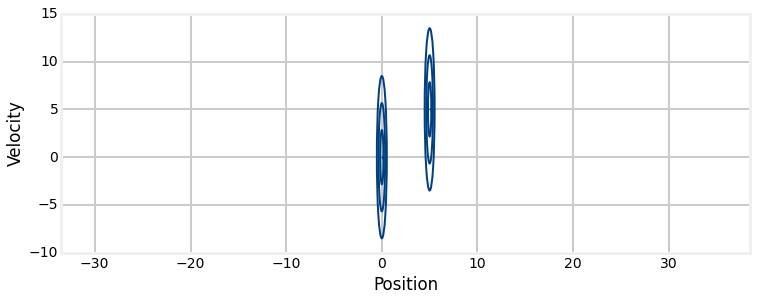

In [27]:
mkf_internal.show_x_error_chart(2)

But of course position and velocity are correlated. If the velocity is 5 m/s the position would be 5, but if the velocity was 10 m/s the position would be 10. So let's draw a velocity covariance matrix in red.

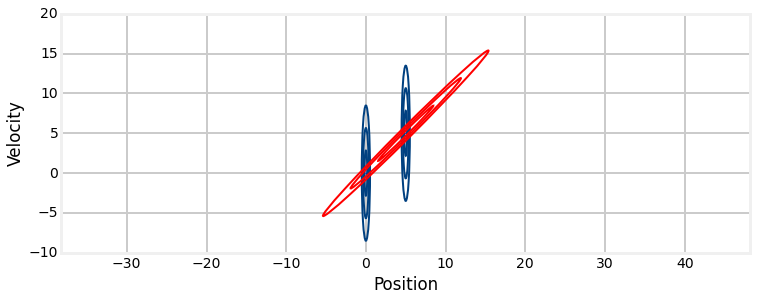

In [28]:
mkf_internal.show_x_error_chart(3)

This superposition of the two covariances is where all the magic happens. The only reasonable estimate at time t=1 (where position=5) is roughly the *intersection* between the two covariance matrices! More exactly, we can use the math from the last section and *multiply* the two covariances together. If we multiply the position covariance with the velocity covariance using the equations above, we get the result shown in the next chart.

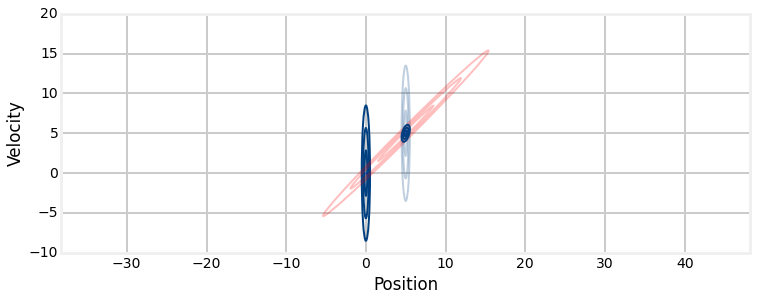

In [29]:
mkf_internal.show_x_error_chart(4)

We can see that the new covariance lies at the intersection of the position covariance and the velocity covariance. It is slightly tilted, showing that there is some correlation between the position and velocity. Far more importantly, it is far smaller than either the position or velocity covariances that make it up. In the previous chapter our variance would get smaller each time we performed an `update()` because the previous estimate's Gaussian was multiplied by the new measurement's Gaussian. The same thing is happening here. However, the amount that the covariance got smaller by is much larger in this chapter. This is because we are using two different kinds of information which are nevertheless correlated. Knowing the velocity approximately and the position approximately allows us to very quickly hone in on the correct answer. 

This is a *key point* in Kalman filters, so read carefully! Our sensor is only detecting the position of the aircraft (how doesn't matter). It does not have any kind of sensor that provides velocity to us. But based on the position estimates we can compute velocity. In Kalman filters we would call the velocity an **unobserved variable**. Unobserved means what it sounds like - there is no sensor that is measuring velocity directly. Since the velocity is based on the position, and the position has error, the velocity will have error as well. But as we can see the correlation between velocity and position means that we can very quickly eliminate most of that error.

What makes this possible? Imagine for a moment that we superimposed the velocity from a *different* airplane over the position graph. Clearly the two are not related, and there is no way that combining the two could possibly yield any additional information. In contrast, the velocity of this airplane tells us something very important - the direction and speed of travel. So long as the aircraft does not alter its velocity the velocity allows us to predict where the next position is. After a relatively small amount of error in velocity the probability that it is a good match with the position is very small. Think about it - if you suddenly change direction your position is also going to change a lot. If the measurement of the position is not in the direction of the  velocity change it is very unlikely to be true. The two are correlated, so if the velocity changes so must the position, and in a predictable way. 

We are going to see this again and again in the rest of the book, so don't worry if this feels a bit magical to you. But it is important to understand that we are taking advantage of the fact that velocity and position are correlated combined with the ability to infer velocity by looking at the distance and time between two measurement, to produce very accurate estimates after only a few observations. Please reread this section if you have any doubts. If you grasp this point the rest is straightforward. If you do not you will quickly find it impossible to reason about what you will learn in the rest of this chapter.

In summary we have taken advantage of the geometry and correlations of the system to produce a very accurate estimate. The math does not care whether we are working with two positions, or a position and a correlated velocity. If we can express our uncertainties as a multidimensional Gaussian we can then multiply our uncertainty in position with our uncertainty in velocity and get a much more accurate result, in exactly the same way we can multiply the uncertainty in two position estimates to get a more accurate result.

## Kalman Filter Algorithm

Now that we have that under our belts we can show how a Kalman filter works. The algorithm is the same that we used in the last chapter:

**Initialization**

    1. Initialize the state of the filter
    2. Initialize our belief in the state - how accurate do we think it is
    
**Predict**

    1. Based on the system behaves, predict its state at the next time step
    2. Adjust belief in that state to account for the uncertainty in prediction
    
**Update**

    1. Get a measurement and associated belief about its accuracy
    2. Compute difference (residual) between our estimated state and measurement
    3. Compute scaling factor (Kalman gain) based on whether the measurement or prediction is more accurate
    4. set state between the prediction and measurement based on scaling factor
    5. update belief in the state based on how certain we are in the measurement

The previous sections may lead you to believe that we have to write some fairly sophisticated code to extract the velocity from the position and then more code to produce estimates by combining the covariances together, but that is not so. Everything I explained above happens automatically as a result of how multivariate Gaussians work. In the last section I didn't do anything more than add and multiply the Gaussians. The geometric layout of the scene combined with the correlations between variables fully determined the solution. The Kalman filter equations look quite a bit different from the equations in the last section because they are a bit more generalized and they work with multivariate Gaussians, but it is the same algorithm. In fact, we will show later that if your problem only has one dimension these equations can be algebraically changed to the equations in the last chapter.

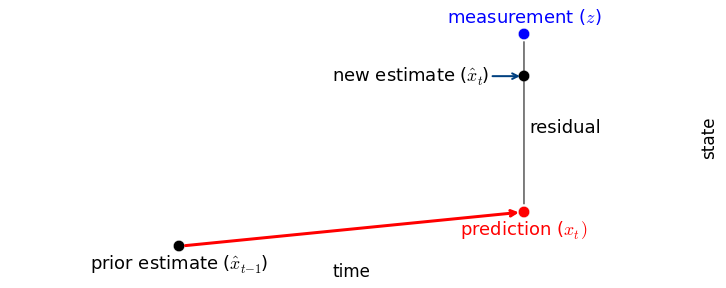

In [30]:
from mkf_internal import show_residual_chart
show_residual_chart()

## The Equations

The brilliance of the Kalman filter is taking the insights of the chapter up to this point and finding an optimal mathematical solution. The Kalman filter finds what is called a *least squared fit* to the set of measurements to produce an optimal output. We will not trouble ourselves with the derivation of these equations. It runs to several pages, and offers a lot less insight than the words above, in my opinion. Furthermore, to create a Kalman filter for your application you will not be manipulating these equations, but only specifying a number of parameters that are used by them. It would be going too far to say that you will never need to understand these equations; but to start we can pass them by and I will present the code that implements them. So, first, let's see the equations. 
> Kalman Filter Predict Step:
>
> $$
\begin{aligned}
\hat{\textbf{x}}^-_{k+1} &= \mathbf{F}_{k}\hat{\textbf{x}}_{k} + \mathbf{B}_k\mathbf{u}_k\;\;\;&(1) \\
\textbf{P}^-_{k+1} &=  \mathbf{F}_k \textbf{P}_k\mathbf{F}_k^\mathsf{T} + \textbf{Q}_{k}\;\;\;&(2)
\end{aligned}
$$

> Kalman Filter Update Step:
>
>$$
\begin{aligned}
\mathbf{S}_k &= \textbf{H}_k\textbf{P}^-_k\textbf{H}_k^\mathsf{T} + \textbf{R}_k \;\;\;&(3) \\
\textbf{K}_k &= \textbf{P}^-_k\textbf{H}_k^\mathsf{T}\mathbf{S}_k^{-1}\;\;\;&(4) \\
\textbf{y}_k &= \textbf{z}_k - \textbf{H}_k\hat{\textbf{}x}^-_k\;\;\;&(5) \\
\hat{\textbf{x}}_k  &= \hat{\textbf{x}}^-_k +\textbf{K}_k\textbf{y} \;\;\;&(6)\\
\mathbf{P}_k &= (\mathbf{I}-\mathbf{K}_k\mathbf{H}_k)\mathbf{P}^-_k\;\;\;&(7)
\end{aligned}
$$

Dash off, wipe the blood out of your eyes, and we'll discuss what this means. 

These are nothing more than linear algebra equations that implement the algorithm we used in the last chapter, but using multidimensional Gaussians instead of univariate Gaussians, and optimized for a least squares fit.


Different texts use different notation and variable names for the Kalman filter. Later we will expose you to these different forms to prepare you for reading the original literature. In the equations above I have adopted the variable names used by the Wikipedia article[2] on Kalman filters. Each bold letter denotes a matrix or vector. The subscripts indicate which time step the data comes from; $k$ is now, $k+1$ is the next step. The caret (^) indicates that the value is an estimate. Finally, I particularly like how Brown [3] uses a raised $^-$ to denote a prediction, and so I have adopted that approach.

For a matrix $\mathbf{A}$, $\mathbf{A}^\mathsf{T}$ signifies its transpose, and $\mathbf{A}^{-1}$ its inverse. So, taken together, $\hat{\mathbf{x}}^-_{k+1}$ represents the prediction for the estimate of $\mathbf{x}$ at time step $k+1$, where $\mathbf{x}$ is some vector in the form $\mathbf{x} = \begin{bmatrix}x_1&x_2&..&x_n\end{bmatrix}^\mathsf{T}.$ 

### Kalman Equations Expressed as an Algorithm


However, I still find  the notation to be a bit dense, and unnecessarily complicated for writing code. The subscripts indicate the time step, but when we write code it is very clear what is being calculated at each time step. For most of this book I'm going to use the following simplified equations, which express an algorithm.

$$
\begin{aligned}
\text{Predict Step}\\
\mathbf{x^-} &= \mathbf{F x} + \mathbf{B u}\;\;\;&(1) \\
\mathbf{P^-} &= \mathbf{FP{F}}^\mathsf{T} + \mathbf{Q}\;\;\;&(2) \\
\\
\text{Update Step}\\
\textbf{S} &= \mathbf{HP^-H}^\mathsf{T} + \mathbf{R} \;\;\;&(3)\\
\mathbf{K} &= \mathbf{P^-H}^\mathsf{T} \mathbf{S}^{-1}\;\;\;&(4) \\
\textbf{y} &= \mathbf{z} - \mathbf{H x^-} \;\;\;&(5)\\
\mathbf{x} &=\mathbf{x^-} +\mathbf{K\textbf{y}} \;\;\;&(6)\\
\mathbf{P} &= (\mathbf{I}-\mathbf{KH})\mathbf{P^-}\;\;\;&(7)
\end{aligned}
$$

What do all of the variables mean? What is $\mathbf{P}$, for example? Don't worry right now. Instead, I am just going to design a Kalman filter, and introduce the names as we go. Then we will just pass them into Python function that implement the equations above, and we will have our solution. Later sections will then delve into more detail about each step and equation. I think learning by example and practice is far easier than trying to memorize a dozen abstract facts at once.  

## Implementation in Python

Before we go any further let's gain some familiarity with the equations by programming them in Python. I have written a production quality implementation of the Kalman filter equations in my `FilterPy` library, and we will be using that later in the chapter and the remainder of the book. We could just look at that code, but it contains a significant amount of code to ensure that the computations are numerically stable, that you do not pass in bad data, and so on. Let's just try to program this.

The filter equations are *linear algebra* equations, so we will use the Python library that implements linear algebra - NumPy. In the filter equations a **bold** variable denotes a matrix. Numpy provides two types to implement matrices: `numpy.array` and `numpy.matrix`. You might suspect that the latter is the one we want to use. As it turns out `numpy.matrix` does support linear algebra well, except for one problem - most of the rest of `numpy` uses `numpy.array`, not `numpy.matrix`. You can pass a `numpy.matrix` into a function, and get a `numpy.array` back as a result. Hence, the standard advice is that `numpy.matrix` is deprecated, and you should always use `numpy.array` even when `numpy.matrix` is more convenient. I ignored this advice in a early version of this code and ended up regretting that choice, and so now I use `numpy.array` only.

Let's start with the prediction equations.

$$
\begin{aligned}
\mathbf{x^-} &= \mathbf{F x} + \mathbf{B u}\\
\mathbf{P^-} &= \mathbf{FPF}^\mathsf{T} + \mathbf{Q}
\end{aligned}
$$

Those are linear algebra equations using matrix multiplication and addition. Assuming each variable is already defined somewhere, we can implement these equations in Python and NumPy with:

    from numpy import dot
    x = dot(F, x) + dot(B, u)
    P = dot(F, P).dot(F.T) + Q

That is all there is to it! We are using `numpy.dot` to perform the matrix multiplications.

Now let's do the update step. Again, they consist of matrix multiplication and addition. There is also a matrix inverse, which is implemented by `numpy.linalg.inv()`. In Python we would write:

    y = z - dot(H, x)
    S = dot(H, P).dot(H.T) + R
    K = dot(P, H.T).dot(np.linalg.inv(S))
    x = x + dot(K,y)
    P = (I - dot(K, H)).dot(P)
    
And that is it, we have implemented a Kalman filter!

Well, you probably do not want to cut and paste that code into every project that uses a Kalman filter. So let's put this into a class. I don't intend to teach you how to program here, so I will instead point you to my `KalmanFilter` class from my FilterPy module, available on github [4]. You can import the class from `FilterPy` using the following import statement, and that is what we will do in the rest of this chapter and book:

In [58]:
from filterpy.kalman import KalmanFilter

## Tracking a Dog

Let's go back to our tried and true problem of tracking our dog. This time we will include the fundamental insight of this chapter - that of using *unobserved variables* to improve our estimates. In simple terms, if we let the position be called `x`, our algorithm is:

    1. predict the next x with "x + vel*time".
    2. add uncertainty caused by prediction to covariance
    3. measure the system with a sensor
    4. Convert x into a measurement so we can do the next step
    5. compute measurement residual as: "measurement - x converted to measurement"
    6. compute kalman gain based on noise levels in prediction and measurement
    7. compute new x as "x + (residual * kalman gain)"
    8. compute covariance for x to account for additional
       information the measurement provides
    
That is the entire Kalman filter algorithm. It is both what we described above in words, and it is what the rather obscure Kalman Filter equations do. This is the same algorithm we used in the last chapter except here $x$ can be multidimesional (it can contain positions in the x-axis and y-axis, velocities, accelerations, and so on). And since $x$ is multidimensional our variance must also be multidimensional, so it becomes a **covariance**. The Kalman filter equations just express this algorithm by using linear algebra. 

Step 4 might be confusing. Suppose we are measuring temperature. The thermometer may provide readings in volts, and thus the noise in the reading is also expressed as volts, not temperature. The Kalman filter will convert everything into volts so it can compute the Kalman gain in terms of volts, not temperature, and then convert everything back to temperatures. This is called working in the **measurement space**. We'll see how that works soon.

As I mentioned above, there is actually very little programming involved in creating a Kalman filter. We will just be defining several matrices and parameters that get passed into  the Kalman filter algorithm code. 

## Designing the Kalman Filter

Rather than try to explain each of the steps ahead of time, which can be a bit abstract and hard to follow, let's just do it for our by now well known dog tracking problem. Naturally this one example will not cover every use case of the Kalman filter, but we will learn by starting with a simple problem and then slowly start addressing more complicated situations. But based on the algorithm above we can see that we have 

### **Step 1:** Choose the State Variables and Set Initial Conditions

In the previous chapter we tracked a dog in one dimension by using a Gaussian. The mean $(\mu)$ represented the most likely position, and the variance ($\sigma^2$) represented the probability distribution of the position. In that problem the position is the *state* of the system, and we call $\mu$ the *state variable*.

In this chapter we will be tracking both the position and velocity of the dog, so we have two state variables. It is important to understand that this is a design choice with implications and assumptions that we are not yet prepared to explore. For example, we could also track acceleration, or even jerk. Later we will learn the benefits and costs of doing that, but this is a good starting point.

State variables can either be *observed variables* - directly measured by a sensor, or *unobserved variables* - inferred from the observed variables. For our dog tracking problem, our observed state variable is position, and the unobserved variable is velocity. 

In the previous chapter we would denote the dog's position being 3.2 meters as:

$$\mu = 3.2$$

In this chapter we will use the multivariate Gaussian as described at the beginning of this chapter. For example, if we wanted to specify a position of 10.0 m and a velocity of 4.5 m/s, we would write:

$$\mu = \begin{bmatrix}10.0\\4.5\end{bmatrix}$$

The Kalman filter is implemented using linear algebra. We use an $n\times 1$ matrix to store  $n$ state variables. For the dog tracking problem, we use $x$ to denote position, and the first derivative of $x$, $\dot{x}$, for velocity. The Kalman filter equations use $\mathbf{x}$ for the state, so we define $\mathbf{x}$ as:

$$\mathbf{x} =\begin{bmatrix}x \\ \dot{x}\end{bmatrix}$$

We use $\mathbf{x}$ instead of $\mu$, but recognize this is just the mean of the multivariate Gaussian. It is common to use the transpose notation to write the state variable as $\mathbf{x} =\begin{bmatrix}x & \dot{x}\end{bmatrix}^\mathbf{T}$ because the transpose of a row vector is a column vector.

One point that might be confusing: $\mathbf{x}$ and $x$ somewhat coincidentally have the same name. If we were tracking the dog in the y-axis we would write $\mathbf{x} =\begin{bmatrix}y & \dot{y}\end{bmatrix}^\mathsf{T}$.

The other half of the Gaussian is the covariance $\Sigma$. The Kalman filter equations use the alternative symbol $\mathbf{P}$, but it means the same thing. In the one dimensional Kalman filter we specified an initial value for $\sigma^2$, and then the filter took care of updating its value as measurements were added to the filter. The same thing happens in the multidimensional Kalman filter.

In the last chapter we initialized the dog's position at 0.0 m, and set the $\sigma^2=500\, m^2$ to indicate that we were very unsure about this initial value. We need to do the same thing for the multidimensional Kalman filter. We will set the initial position to 0.0 m, the initial velocity to 0.0 m/s, and then set $\sigma^2$ to a 500 for both the position and velocity to reflect our uncertainty. 

Recall that the diagonals of the covariance matrix contains the variance of each variable. So to initialize the Kalman filter to the values in the previous paragraph we would write:

$$
\mathbf{x} = \begin{bmatrix}0 \\ 0\end{bmatrix},\, \,
\mathbf{P} = \begin{bmatrix}500 & 0 \\ 0&500\end{bmatrix}
$$

I am often frustrated when books use the same value for multiple variables in an example as it can be unclear which value corresponds to which variable. To ensure that there is no confusion let's look at the example of setting the initial position to 1 m, the initial velocity to 2.3 m/s, the $\sigma^2$ of the position to $500\, m^2$, and the $\sigma^2$ of the velocity to $400\, m^2$. In that case we would write:

$$
\mathbf{x} = \begin{bmatrix}1 \\ 2.3\end{bmatrix},\, \,
\mathbf{P} = \begin{bmatrix}500 & 0 \\ 0&400\end{bmatrix}
$$

### **Step 2:** Design the State Transition Function

The next step in designing a Kalman filter is telling it how to predict the next state from the current state. We do this by providing it with equations that describe the physical model of the system. For example, for our dog tracking problem we are tracking a moving object, so we just need to provide it with the Newtonian equations for motion. If we were tracking a thrown ball we would have to provide equations for how a ball moves in a gravitational field, and perhaps include the effects of things like air drag. If we were writing a Kalman filter for a rocket we would have to tell it how the rocket responds to its thrusters and main engine. A Kalman filter for a bowling ball would incorporate the effects of friction and ball rotation. You get the idea. 

In the language of Kalman filters the physical model is sometimes called the **process model**. That is probably a better term than *physical model* because the Kalman filter can be used to track non-physical things like stock prices. We describe the process model with a set of equations we call the **State Transition Function.** 


We know from elementary physics how to compute a future position given our current position and velocity. Let $x$ be our current position, and $\Delta t$ be the amount of time in the future. The velocity is then the derivative of $x$ with respect to time, which we notate as $\dot{x}$. We can then write 

$$x_t = \dot{x}_{t-1}\Delta t + x_{t-1}$$

To avoid subscripts we will adopt notation that uses $x^-$ to denote our predicted position, and write

$$x^- = \dot{x}\Delta t + x$$

Equation (1) of the Kalman filter $\mathbf{x^-} = \mathbf{Fx} + \mathbf{B u}$ implements the *state transition function* that we are discussing. This requires us to formulate the motion equations with matrices, so let's learn how to do that now. For the moment we will ignore the $\mathbf{B u}$ term, as for our problem it turns out that it is equal to zero. This will be explained in step 3. Thus, we must express our equations in the form 
$\mathbf{x}^- = \mathbf{Fx}.$

A quick review on how to represent linear equations with matrices. Take the following two equations:

$$2x+3y = 8\\3x-y=1$$

We can put this in matrix form by writing:

$$
\begin{bmatrix}2& 3 \\ 3& -1\end{bmatrix}\begin{bmatrix}x\\y\end{bmatrix}=\begin{bmatrix}8\\1\end{bmatrix}$$

If you perform the matrix multiplication in this equation the result will be the two equations above.

So, given that $\mathbf{x} = \begin{bmatrix}x \\ \dot{x}\end{bmatrix}$ we can write:

$$
\begin{aligned}
\mathbf{x}^- &= \mathbf{Fx} \\
\begin{bmatrix}x \\ \dot{x}\end{bmatrix}^- &= \mathbf{F}\begin{bmatrix}x \\ \dot{x}\end{bmatrix}
\end{aligned}
$$

Since $\mathbf{x}$ is a $2{\times}1$ matrix $\mathbf{F}$ must be a $2{\times}2$ matrix to yield another $2{\times}1$ matrix as a result. The first row of the F is easy to derive:

$$
\begin{aligned}
{\begin{bmatrix}x\\\dot{x}\end{bmatrix}}^- &=\begin{bmatrix}1&\Delta t \\ ?&?\end{bmatrix} \begin{bmatrix}x \\ \dot{x}\end{bmatrix}
\end{aligned}
$$

When we multiply the first row of $\mathbf{F}$ that out we get:

$$ 
\begin{aligned}
x^- &= 1  x + \Delta t \dot{x} \mbox{, or} \\
x^- &= \dot{x}\Delta t + x
\end{aligned}
$$

which is our equation for computing the new position based on velocity, time, and the previous position.

Now we have to account for the second row. I've left it somewhat unstated up to now, but we are assuming constant velocity for this problem. Naturally this assumption is not true; if our dog moves it must accelerate and decelerate. If you cast your mind back to the *g-h Filter* chapter we explored the effect of assuming constant velocity. So long as the acceleration is small compared to $\Delta t$ the filter will still perform well. 

Therefore we will assume that

$$\dot{x}^- = \dot{x}$$

which gives us the second row of $\mathbf{F}$ as follows:


$$
{\begin{bmatrix}x\\\dot{x}\end{bmatrix}}^- =\begin{bmatrix}1&\Delta t  \\ 0&1\end{bmatrix} \times \begin{bmatrix}x \\ \dot{x}\end{bmatrix}
$$

Which, when multiplied out, yields our desired equations:

$$
\begin{aligned}
x^- &= x + \dot{x} \\
\dot{x}^- &= \dot{x}
\end{aligned}
$$

In the vocabulary of Kalman filters we call this *transforming the state matrix*. We take our state matrix, which for us is $(\begin{smallmatrix}x \\ \dot{x}\end{smallmatrix})$, and multiply it by a matrix we will call $\mathbf{F}$ to compute the new state. 


You will do this for every Kalman filter you ever design. Your state matrix will change depending on how many state random variables you have, and then you will create $\mathbf{F}$ so that it updates your state based on whatever the physics of your problem dictates. If this is not fully clear, don't worry, we will do this many times in this book. The important thing to understand is that we have described how to predict the state of the system based on the current state. 

### **Step 3**: Design the Control Function

The Kalman filter does not just filter data, it allows us to incorporate control inputs for systems like robots and airplanes. Consider the state transition function we wrote for the dog:

$$x_t = \dot{x}(\Delta t) + x_{t-1}$$

Suppose that instead of passively tracking our dog we were actively controlling a robot. At each time step we would send control signals to the robot based on its current position vs desired position. Kalman filter equations incorporate that knowledge into the filter equations, creating a predicted position based both on current velocity *and* control inputs to the drive motors. 

We will cover this use case later, but for now we set those terms to 0. In step 2 there was the unexplained term $\mathbf{Bu}$ in equation (1):

$$\mathbf{x^-} = \mathbf{Fx} + \mathbf{Bu}$$

Here $\mathbf{u}$ is the control input, and $\mathbf{B}$ is the control input model. For example, $\mathbf{u}$ might be a voltage controlling how fast the wheel's motor turns, and multiplying by $\mathbf{B}$ yields $[\begin{smallmatrix}x\\\dot{x}\end{smallmatrix}]$. Since we do not need these terms we will set them both to zero and not concern ourselves with them for now.

Another use for this term is to incorporate external forces such as gravity into your model. 

### **Step 4**: Design the Measurement Function

The Kalman filter computes the update step in what we call *measurement space*. We mostly ignored this issue in the previous chapter because of the complication it adds. In the last chapter we tracked our dog's position using a sensor that reported his position. Computing the *residual* was easy - subtract the filter's predicted position from the measurement:

$$ residual = measured\,position - estimated\,position$$

However, consider what would happen if we were trying to track temperature using a thermometer that outputs a voltage corresponding to the temperature reading. The equation for the residual computation would be nonsense; you can't subtract a temperature from a voltage.

$$ residual = voltage - temperature\;\;\;(BAD!)$$

The Kalman filter generalizes this problem by having you supply a **measurement function**. It is somewhat counterintuitive at first. As I already stated the Kalman filter performs its calculations in *measurement space.*  It needs to do that because it only really makes sense to talk about the residual of the measurement in terms of the measurement. So it does something like this:

    CELSIUS_TO_VOLTS = 0.21475 # constant from manufacturer's spec
    residual = measurement - CELSIUS_TO_VOLTS * predicted_state

In other words, for the thermometer tracking problem, it would take the filter's current prediction of temperature, convert that to whatever voltage would represent that temperature, and then subtract it from the current thermometer voltage output. This gives it a residual in the correct units (volts).

Both the measurement $\mathbf{z}$ and state $\mathbf{x}$ are vectors so we need to use a matrix to perform the conversion. The Kalman filter equation that performs this step is:

$$\textbf{y} = \mathbf{z} - \mathbf{H x^-}$$

where $\textbf{y}$ is the residual, $\mathbf{x^-}$ is the predicted value for $\mathbf{x}$, $\textbf{z}$ is the measurement, and $\textbf{H}$ is the measurement function matrix that we multiply the state into to convert it into measurement space.

In other words we need to design $\mathbf{H}$ so that $\textbf{Hx}^-$ yields a measurement. For this problem we have a sensor that measures position, so $\mathbf{z}$ will be a one element vector:

$$\mathbf{z} = \begin{bmatrix}x \end{bmatrix}$$

The state is $\mathbf{x}=\begin{bmatrix}x & \dot{x}\end{bmatrix}^\mathsf{T}$ so $\mathbf{H}$ has to be a $1\times 2$ matrix. Recall that multiplying matrices $m\times n$ by $n\times p$ yield one of size $m\times p$. So the equation will have the form

$$
\begin{aligned}
&\textbf{y} = &\mathbf{z} &- &\mathbf{H}&\mathbf{x^-}  \\
&\begin{bmatrix}x \end{bmatrix} = &\begin{bmatrix}x \end{bmatrix} &- &\begin{bmatrix}?&?\end{bmatrix} &\begin{bmatrix}x \\ \dot{x}\end{bmatrix}
\end{aligned}
$$


So we will want to multiply the position $x$ by 1 to get the corresponding measurement of the position, and multiply the velocity $\dot{x}$ by 0 to get the corresponding measurement of velocity (of which there is none).

$$
\textbf{y} = \mathbf{z} - \begin{bmatrix}1&0\end{bmatrix} \begin{bmatrix}x \\ \dot{x}\end{bmatrix}
$$

And so, for our Kalman filter we set

$$\mathbf{H}=\begin{bmatrix}1&0\end{bmatrix}$$

Believe it or not, we have designed the majority of our Kalman filter!! All that is left is to model the noise in our sensors.

### **Step 5**: Design the Measurement Noise Matrix

The *measurement noise matrix* is a matrix that models the noise in our sensors as a covariance matrix. This can be admittedly a very difficult thing to do in practice. A complicated system may have many sensors, the correlation between them might not be clear, and usually their noise is not a pure Gaussian. For example, a sensor might be biased to read high if the temperature is high, and so the noise is not distributed equally on both sides of the mean. Later we will address this topic in detail. For now I just want you to get used to the idea of the measurement noise matrix so we will keep it deliberately simple.

In the last chapter we used a variance of 5 meters for our position sensor. Let's use the same value here.  The Kalman filter equations uses the symbol $R$ for this matrix. In general the matrix will have dimension $m{\times}m$, where $m$ is the number of sensors. It is $m{\times}m$ because it is a covariance matrix, as there may be correlations between the sensors. We have only 1 sensor here so we write:

$$R = \begin{bmatrix}5\end{bmatrix}$$

If we had two position sensors, the first with a variance of 5 meters squared, the second with a variance of 3 meters squared, we would write

$$R = \begin{bmatrix}5&0\\0&3\end{bmatrix}$$

We put the variances on the diagonal because this is a *covariance* matrix, where the variances lie on the diagonal, and the covariances, if any, lie in the off-diagonal elements. Here we assume there is no correlation in the noise between the two sensors, so the covariances are 0.

### **Step 6**: Design the Process Noise Matrix

What is **process noise**? Consider the motion of a thrown ball. In a vacuum and with constant gravitational force it moves in a parabola. However, if you throw the ball on the surface of the earth you will also need to model factors like rotation and air drag. However, even when you have done all of that there is usually things you cannot account for. For example, consider wind. On a windy day the ball's trajectory will differ from the computed trajectory, perhaps by a significant amount. Without wind sensors, we may have no way to model the wind. 

We can model this system with

$$\dot{\mathbf{x}} = \mathbf{Fx} +\mathbf{Bu}+w$$

where $\mathbf{Fx}$ is the state transition, $\mathbf{Bu}$ is the control input, and $w$ is the process noise, which we assume is white. In other words $\mathbf{Fx} + \mathbf{Bu}$ is our model of the system, and $w$ is things like winds, control surface fluctuations, maybe circuit noise - whatever affects our process that is not modeled.


As you know the Kalman filter models the system state with a multivariate Gaussian. $\mathbf{x}$ contains the mean, and $\mathbf{P}$ contains the covariance. So to account for the unmodelled behavior in the system the filter adds a *process noise* covariance matrix $\mathbf{Q}$ to $\mathbf{P}$ to account for the uncertainty that the process noise contributes to the system. We cannot add anything to $\mathbf{x}$ because we do not have any knowledge about the magnitude of the noise. Furthermore, we assume that the noise is *white* - which means that the mean of the noise will be 0. 

Now we can inspect the Kalman filter predict equations and understand them.


$$
\begin{aligned}
\mathbf{x^-} &= \mathbf{F x} + \mathbf{B u} \\
\mathbf{P^-} &= \mathbf{FPF}^\mathsf{T} + \mathbf{Q} \\
\end{aligned}
$$

We already explained that the first equation updates the state using the system model and control input.

The second equation does two things. Recall what happened to the variance when we performed the predict step in the *Discrete Bayes* chapter and the *Kalman Filter* chapter. Because we are predicting forward in time we lose some certainty about the state. In the *Discrete Bayes* chapter we wrote:

    sigma = sigma + movement_sigma

In this chapter $\mathbf{FPF}^\mathsf{T}$ adjusts $\mathbf{P}$ based on the motion that occurs as modelled by $\mathbf{F}$. It is the equivalent of `sigma + movement_sigma` from the *Discrete Bayes* chapter, but for multivariate Gaussians. You can get a feel for how $\mathbf{FPF}^\mathsf{T}$ works with this code:

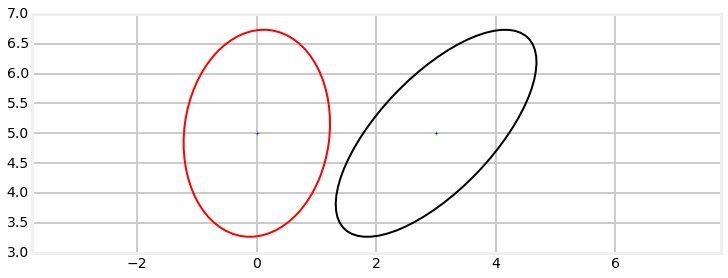

In [59]:
import numpy as np

dt = 0.6
x = np.array([0., 5.])
F = np.array([[1., dt], [0, 1.]])
P = np.array([[1.5, 0.2], [0.2, 3.]])
plot_covariance_ellipse(x, P, edgecolor='r')

x = np.dot(F, x)
P = np.dot(F, P).dot(F.T)
plot_covariance_ellipse(x, P, edgecolor='k')

The *Discrete Bayes* chapter did not take the the process noise into account. We can model the process noise as additional uncertainty, so we could write

    sigma = sigma + movement_sigma + process_noise

We model the process noise with the covariance matrix $\mathbf{Q}$. Process noise adds uncertainty into the system, so we add it to $\mathbf{P}$. Here are the equations from the *Discrete Bayes* chapter and this chapter so you can compare them. They are doing the same thing; they look different only because the algebra for multivariate Gaussians is different than for univariate Gaussians.

$$\begin{aligned}
sigma &= (sigma + movement\, sigma) + process\, noise\\
\mathbf{P^-} &= (\mathbf{FPF}^\mathsf{T}) + \mathbf{Q}
\end{aligned}$$

Designing the process noise matrix can be quite demanding, and we will put it off until the Kalman math chapter. For now I will say that $\mathbf{Q} = E[\mathbf{ww}^\mathsf{T}]$ ($E[]$ is the notation for *expected value*). In this chapter we will focus on building an intuitive understanding on how modifying this matrix alters the behavior of the filter. FilterPy provides functions to automatically compute $\mathbf{Q}$ for the kinematic problems we are solving in this chapter, and we will use that to compute $\mathbf{Q}$.

In [60]:
from filterpy.common import Q_discrete_white_noise
help(Q_discrete_white_noise)

Help on function Q_discrete_white_noise in module filterpy.common.discretization:

Q_discrete_white_noise(dim, dt=1.0, var=1.0)
    Returns the Q matrix for the Discrete Constant White Noise
    Model. dim may be either 2 or 3, dt is the time step, and sigma is the
    variance in the noise.
    
    Q is computed as the G * G^T * variance, where G is the process noise per
    time step. In other words, G = [[.5dt^2][dt]]^T for the constant velocity 
    model.
    
    **Paramaeters**
    
    dim : int (2 or 3)
        dimension for Q, where the final dimension is (dim x dim)
    
    dt : float, default=1.0
        time step in whatever units your filter is using for time. i.e. the
        amount of time between innovations
    
    var : float, default=1.0
        variance in the noise



In [61]:
Q = Q_discrete_white_noise(dim=2, dt=0.1, var=2.35)
Q

array([[ 0.00005875,  0.001175  ],
       [ 0.001175  ,  0.0235    ]])

## Implementing the Kalman Filter

As we already explained, the Kalman filter equations are already implemented for you in the `FilterPy` library, so let's start by importing it and creating a filter. 

In [62]:
from filterpy.kalman import KalmanFilter
dog_filter = KalmanFilter(dim_x=2, dim_z=1)

That's it. We import the filter create it. We specify the dimension of thes tate variable $\mathbf{x}$ with the `dim_x=2` expression (dim means dimensions), and the dimension of the measurement $\mathbf{z}$ with `dim_z=1`.

The Kalman filter class contains a number of variables that you need to initialize. `x` is the state, `F` is the state transition function, and so on.

In [63]:
dog_filter.x = np.array([0., 0.])                         # state (location and velocity)
dog_filter.F = np.array([[1., 1.], 
                         [0., 1.]])                       # state transition function
dog_filter.H = np.array([[1., 0.]])                       # Measurement function
dog_filter.R *=  5                                        # measurement noise
dog_filter.Q = Q_discrete_white_noise(2, dt=0.1, var=0.1) # process noise
dog_filter.P *= 500.                                      # covariance matrix 

Let's look at this line by line. 

**1**: We just assign the initial value for our state. Here we just initialize both the position and velocity to zero.

**2**: We set $\textbf{F}=\begin{bmatrix}1&1\\0&1\end{bmatrix}$, as in design step 2 above. 

**3**: We set $\textbf{H}=\begin{bmatrix}1&0\end{bmatrix}$, as in design step 4 above.

**4**: We set $\textbf{R} = \begin{bmatrix}5\end{bmatrix}$. `R` is initialized to the identity matrix, so multiplying by 5 performs this assignment for us.

**5** We use the `Q_discrete_white_noise()` method to set $\mathbf{Q}$'s variance to 0.1.

**5**: We set $\mathbf{P} = \begin{bmatrix} 500&0\\0&500\end{bmatrix}$. FilterPy initializes `P` to the identity matrix, so multiplying it by 500 performs this assignment.

I've rewritten the creation of the Kalman filter to allow you to specify different initial values for `R`, `P`, and `Q` and put it in a helper function.

In [64]:
def pos_vel_filter(x, P, R, Q=0.):
    dog_filter = KalmanFilter(dim_x=2, dim_z=1)
    dog_filter.x = np.array([x[0], x[1]]) # (location and velocity)
    dog_filter.F = np.array([[1, 1],
                             [0, 1]])     # state transition matrix
    dog_filter.H = np.array([[1, 0]])     # Measurement function
    dog_filter.R *= R                     # measurement uncertainty
    dog_filter.P *= P                     # covariance matrix 
    if np.isscalar(Q):
        dog_filter.Q = Q_discrete_white_noise(dim=2, dt=0.1, var=Q)
    else:
        dog_filter.Q = Q
    return dog_filter

All that is left is to write the code to run the Kalman filter. 

In [65]:
def filter_dog(data, R=0, Q=0, P=500., initial_x=(0., 0.)):
    """ Filters 'data' using the filter provided by 
    dog_tracking_filter().
    
    'initial_x' optional initializes x to some value other than [0, 0].
    
    returns a tuple of (positions, covariance)
    """
    dog_filter = pos_vel_filter(initial_x, R=R, Q=Q, P=P)
    
    pos, cov = [], []    
    for z in data:
        pos.append(dog_filter.x)
        cov.append(dog_filter.P)
    
        # perform the kalman filter steps
        dog_filter.update(z)
        dog_filter.predict()
        
    pos = np.array(pos)
    cov = np.array(cov)
    return (pos, cov)

This is the complete code for the filter, and most of it is just boilerplate. I've made it flexible enough to support several uses in this chapter, so it is a bit verbose. The first function `dog_tracking_filter()` is a helper function that creates a `KalmanFilter` object with specified $\mathbf{R}$, $\mathbf{Q}$ and $\mathbf{P}$ matrices. We've shown this code already, so I will not discuss it more here. 

The function `filter_dog()` implements the filter itself.  Lets work through it line by line. The first line creates the simulation of the DogSensor, as we have seen in the previous chapter.

    dog = DogSensor(velocity=1, noise=noise)

The next line uses our helper function to create a Kalman filter.

    dog_filter = dog_tracking_filter(R=R, Q=Q, cov=500.)
    
We will want to plot the filtered position, the measurements, and the covariance, so we will need to store them in lists. The next three lines initialize empty lists of length *count* in a pythonic way.

    pos = [None] * count
    zs  = [None] * count
    cov = [None] * count
    
Finally we get to the filter. All we need to do is perform the update and predict steps of the Kalman filter for each measurement. The `KalmanFilter` class provides the two functions `update()` and `predict()` for this purpose. `update()` performs the measurement update step of the Kalman filter, and so it takes a variable containing the sensor measurement. 

Absent the bookkeeping work of storing the filter's data, the for loop reads:

    for t in range(count):
        z = dog.sense()
        dog_filter.update (z)
        dog_filter.predict()
    
It really cannot get much simpler than that. As we tackle more complicated problems this code will remain largely the same; all of the work goes into setting up the `KalmanFilter` variables; executing the filter is trivial.

Now let's look at the result. Here is some code that calls `filter_track()` and then plots the result. It is fairly uninteresting code, so I will not walk through it. The `DogSimulation` class from the previous chapter has been placed in `DogSimulation.py`. I have also implemented a few plot routines to visualize the data in  `mkf_internal.py`. Both of these are in the *code* subdirectory if you wish to read them.


In [66]:
from DogSimulation import DogSimulation
from mkf_internal import plot_track

def run_filter(Q, R, P, initial_x=(0.,0.), data=None, count=0, **kwargs):
    if data is None:
        dog = DogSimulation(velocity=1, measurement_variance=R)
        zs = [dog.move_and_sense() for t in range(count)]
    else:
        zs = data
    
    ps, cov = filter_dog(data=zs, R=R, Q=Q, P=P, initial_x=initial_x)
    plot_track(ps[:, 0], zs, cov, **kwargs)
    return ps, cov

Finally, call it. We will start by filtering 50 measurements with a noise variance of 10 and a process variance of 0.01. 

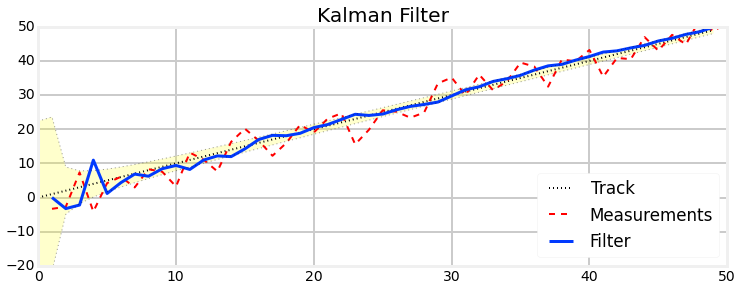

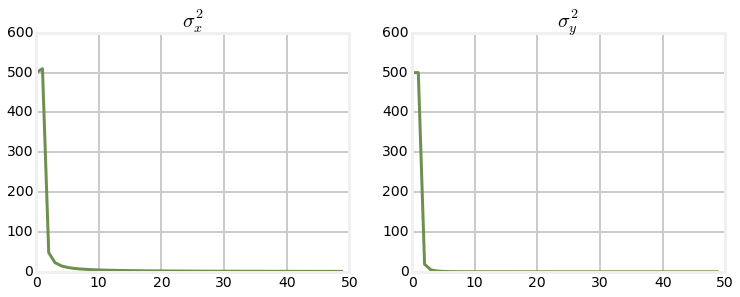

In [67]:
P = np.eye(2) * 500
Ms, Ps = run_filter(count=50, R=10, Q=0.01, P=P, y_lim=(-20, 50))

There is still a lot to learn, but we have implemented our first, full Kalman filter using the same theory and equations as published by Rudolf Kalman! Code very much like this runs inside of your GPS and phone, inside every airliner, inside of robots, and so on. 

The first plot plots the output of the Kalman filter against the measurements and the actual position of our dog (drawn in green). After the initial settling in period the filter should track the dog's position very closely. The yellow shaded portion between the black dotted lines shows 1 standard deviations of the filter's variance, which I explain in the next paragraph.

The next two plots show the variance of $x$ and of $\dot{x}$. If you look at the code, you will see that I have plotted the diagonals of $\mathbf{P}$ over time. Recall that the diagonal of a covariance matrix contains the variance of each state variable. So $\mathbf{P}[0,0]$ is the variance of $x$, and $\mathbf{P}[1,1]$ is the variance of $\dot{x}$. You can see that despite initializing $\mathbf{P}=(\begin{smallmatrix}500&0\\0&500\end{smallmatrix})$ we quickly converge to small variances for both the position and velocity. The covariance matrix $\mathbf{P}$ tells us the *theoretical* performance of the filter *assuming* everything we tell it is true. Recall from the Gaussian chapter that the standard deviation is the square root of the variance, and that approximately 68% of a Gaussian distribution occurs within one standard deviation. Therefore, if at least 68% of the filter output is within one standard deviation we can be sure that the filter is performing well. In the top chart I have displayed the one standard deviation as the yellow shaded area between the two dotted lines. To my eye it looks like perhaps the filter is slightly exceeding that bounds, so the filter probably needs some tuning. We will discuss this later in the chapter.

In the previous chapter we filtered very noisy signals with much simpler code than the code above. However, realize that right now we are working with a very simple example - an object moving through 1-D space and one sensor. That is about the limit of what we can compute with the code in the last chapter. In contrast, we can implement very complicated, multidimensional filter with this code merely by altering are assignments to the filter's variables. Perhaps we want to track 100 dimensions in financial models. Or we have an aircraft with a GPS, INS, TACAN, radar altimeter, baro altimeter, and airspeed indicator, and we want to integrate all those sensors into a model that predicts position, velocity, and accelerations in 3D (which requires 9 state variables). We can do that with the code in this chapter.

I want you to get a better feel for how the Gaussians chnage over time, so here is a 3D plot showing the Gaussians from the plot above. I generated this by computing the probability distribution for each over a large area, and then just summing them together so I can show them all in the same plot. Note that it makes no mathematical sense to add these together, it is just a way to display them all at once. The scale of the y axis is much smaller than the x axis, so the Gaussians look very stretched horizontally, but they are not. This scaling just makes it easier to see everything and minimizes the amount of computation needed. You should still be able to tell that our certainty in both the position and velocity improve over time. We know this because the Gaussian gets narrow in both axis as time increases, and it simultaneously gets taller.

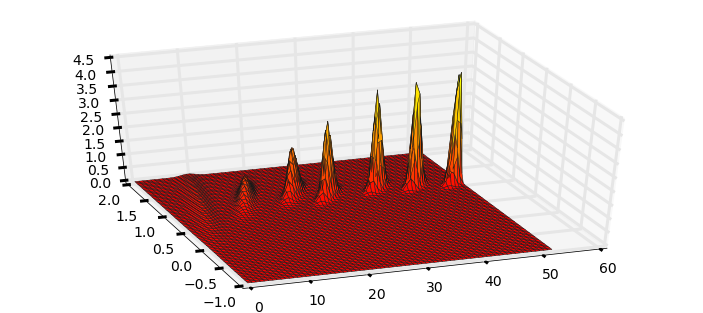

In [68]:
from nonlinear_plots import plot_multiple_gaussians
with figsize(y=5):
    plot_multiple_gaussians(Ms[::7], Ps[::7], (0,52), (-1, 2), 75)

## Exercise: Show Effect of Unobserved Variables

In our filter above velocity is the unobserved variable. How would a filter perform if we did not use velocity in the state?

Write a Kalman filter that uses the state $\mathbf{x}=\begin{bmatrix}x & \dot{x}\end{bmatrix}^\mathsf{T}$ and compare it against the filter in the last exercise which used the state $\mathbf{x}=\begin{bmatrix}x\end{bmatrix}$.

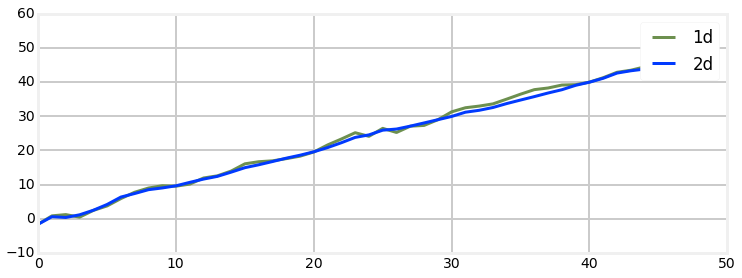

In [77]:
# your code here
from numpy.random import randn
def make_filter(R, Q, p0, x0):
    f = KalmanFilter(dim_x=1, dim_z=1, dim_u=1)
    f.P = p0
    f.H = np.array([[1.]])
    f.F = np.array([[1.]])
    f.B = np.array([[1.]])
    f.Q = Q
    f.R = R
    f.x = [x0]
    return f
    

def compare_pos_vel(x0, p0, R, Q, u0):
    x1, x2 = [], []
    
    f1 = make_filter(R, Q, p0, x0)
    f2 = pos_vel_filter((x0, 1), p0, R, Q=Q)
    
    
    for i in xrange(50):
        u = u0 + randn()
        f1.predict(u=u)
        f2.predict(u=u)
        
        z = x0 + i * u0 + randn()
        f1.update(z)
        f2.update(z)
        
        x1.append(f1.x[0])
        x2.append(f2.x[0])
    plt.plot(x1, label="1d")
    plt.plot(x2, label="2d")
    plt.legend()

compare_pos_vel(0, 50, 5, 1, 1)
    
    

### Solution

We've already implemented a Kalman filter for position and velocity, so I will provide the code without much comment, and then plot the result.

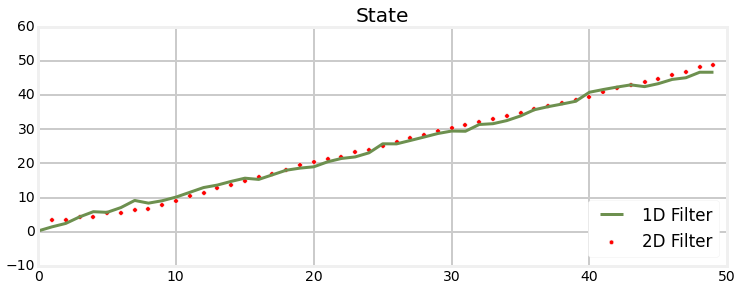

In [78]:
from numpy.random import randn

def mkf_filter(R, Q):
    f = KalmanFilter(dim_x=1, dim_z=1, dim_u=1)
    f.P = 50.
    f.H = np.array([[1.]])
    f.F = np.array([[1.]])
    f.B = np.array([[1.]])
    f.Q = Q
    f.R = R   
    return f

def plot_compare_pos_vel(x0, p0, R, Q, move):
    # storage for filter output
    x1, x2 = [], []

    # initialize the filters
    f1 = mkf_filter(R, Q)
    f1.x[0] = 0.
    f1.P[0, 0] = p0
    
    f2 = pos_vel_filter(x=(0., 1.), P=p0, R=R, Q=Q)
    f2.x[0] = 0.
    f2.x[1] = 1.
    f2.P *= p0
    
    for i in range(50):
        u = move + randn()
        f1.predict(u=u)
        f2.predict(u=u)
        
        z = i*move + randn()
        f1.update(z)
        f2.update(z)
        
        x1.append(f1.x[0, 0])
        x2.append(f2.x[0])

    plt.plot(x1, label='1D Filter')
    plt.scatter(range(len(x2)), x2, c='r', label='2D Filter')
    plt.title('State')
    plt.legend(loc=4)
    plt.xlim([0,50])
    plt.show()
    
plot_compare_pos_vel(x0=0., p0=50., R=5., Q=.2, move=1.)    

### Discussion

The output of the filter that incorporates velocity into the state produces much better output than the filter that only tracks position - the output is much closer to a straight line. We've already discussed why unobserved variables increase the precision of the filter, so I will not repeat that explanation here. But this exercise is intended to trigger a train of thought:

1. The equations in this chapter are mathematically equivalent to the equations in the last chapter when we are only tracking one state variable.
    
2. Therefore, the simple Bayesian reasoning we used in the last chapter applies to this chapter as well.

3. Therefore, the equations in this chapter might 'look ugly', but they really are just implementing multiplying and addition of Gaussians.

> The above might not seem worth emphasizing, but as we continue in the book the mathematical demands will increase significantly. It is easy to get lost in a thicket of linear algebra equations when you read a book or paper on optimal estimation. Any time you start getting lost, just go back to the basics of the predict/update cycle based on residuals between measurements and predictions and the meaning of the math will usually be much clearer. The math *looks* daunting, and can sometimes be very hard to solve analytically, but the concepts are quite simple.

## Adjusting the Filter

Your results will vary slightly depending on what numbers your random generator creates for the noise component of the noise, but the filter in the last section should track the actual position quite well. Typically as the filter starts up the first several predictions are quite bad, and varies a lot. But as the filter builds its state the estimates become much better. 

Let's start varying our parameters to see the effect of various changes. This is a *very normal* thing to be doing with Kalman filters. It is difficult, and often impossible to exactly model our sensors. An imperfect model means imperfect output from our filter. Engineers spend a lot of time tuning Kalman filters so that they perform well with real world sensors. We will spend time now to learn the effect of these changes. As you learn the effect of each change you will develop an intuition for how to design a Kalman filter. As I wrote earlier, designing a Kalman filter is as much art as science. The science is, roughly, designing the ${\mathbf{H}}$ and ${\mathbf{F}}$ matrices - they develop in an obvious manner based on the physics of the system we are modeling. The art comes in modeling the sensors and selecting appropriate values for the rest of our variables.

Let's look at the effects of the noise parameters ${\mathbf{R}}$ and ${\mathbf{Q}}$. We will want to see the effect of different settings for ${\mathbf{R}}$ and ${\mathbf{Q}}$, so I have hard coded our measurements in `zs` based on a variance of 50 meters squared. That is very large, but it magnifies the effects of various design choices on the graphs, making it easier to recognize what is happening. The behavior of the filter is somewhat dependent on the measurements, so I have hard coded them to ensure we all see the same behavior. Note that I use `numpy.var()` to compute the variance of the data - this is an important tactic that you can use if you are running a filter *off-line*, meaning with collected data rather than real time data.  

variance 240.45554425


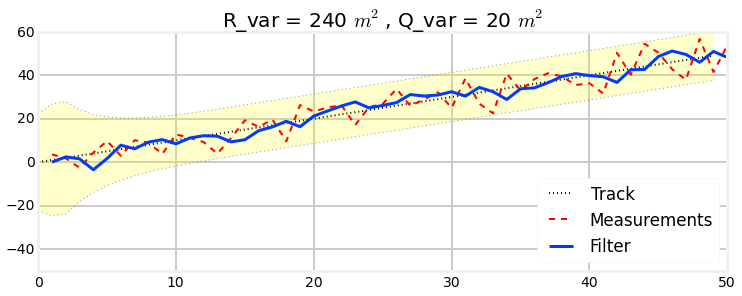

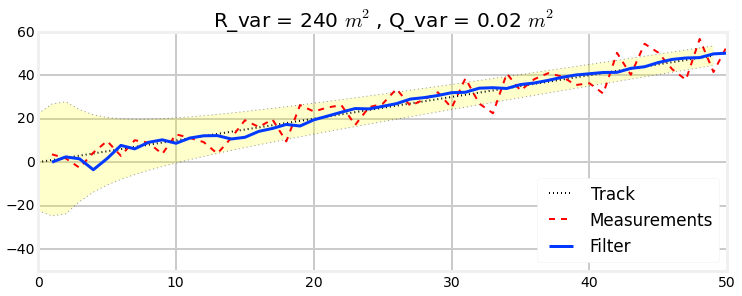

In [44]:
# I've hard coded the measurements to ensure we are all looking 
# at the same data. R~240
zs = [3.59, 1.73, -2.575, 4.38, 9.71, 2.88, 10.08, 8.97, 3.74,
      12.81, 11.15, 9.25, 3.93, 11.11, 19.29, 16.20, 19.63,
      9.54, 26.27, 23.29, 25.18, 26.21, 17.1, 25.27, 26.86,
      33.70, 25.92, 28.82, 32.13, 25.0, 38.56, 26.97, 22.49,
      40.77, 32.95, 38.20, 40.93, 39.42, 35.49, 36.31, 31.56,
      50.29, 40.20, 54.49, 50.38, 42.79, 37.89, 56.69, 41.47, 53.66]
 
print('variance', np.var(zs))
run_filter(data=zs, R=240, Q=200, P=P, plot_P=False, 
           title='R_var = 240 $m^2$, Q_var = 20 $m^2$')

run_filter(data=zs, R=240, Q=.02, P=P, plot_P=False, 
           title='R_var = 240 $m^2$, Q_var = 0.02 $m^2$');

The filter in the first plot should follow the noisy measurement almost exactly. In the second plot the filter should vary from the measurement quite a bit, and be much closer to a straight line than in the first graph. 

In the Kalman filter ${\mathbf{R}}$ is the *measurement noise* and ${\mathbf{Q}}$ is the *process uncertainty*. ${\mathbf{R}}$ is the same in both plots, so ignore it for the moment. Why does ${\mathbf{Q}}$ affect the plots this way?

Let's remind ourselves of what the term *process uncertainty* means. Consider the problem of tracking a ball. We can accurately model its behavior in static air with math, but if there is any wind our model will diverge from reality. 

In the first case we set `Q_var=20 m^2`, which is quite large. In physical terms this is telling the filter "I don't trust my motion prediction step" as we are saying that the variance in the velocity is 10. Strictly speaking, we are telling the filter there is a lot of external noise that we are not modeling with $\small{\mathbf{F}}$, but the upshot of that is to not trust the motion prediction step. So the filter will be computing velocity ($\dot{x}$), but then mostly ignoring it because we are telling the filter that the computation is extremely suspect. Therefore the filter has nothing to use but the measurements, and thus it follows the measurements closely. 

In the second case we set `Q_var=0.02 m^2`, which is quite small. In physical terms we are telling the filter "trust the motion computation, it is really good!". Again, more strictly this actually says there is very small amounts of process noise (variance 0.02 $m^2$), so the motion computation will be accurate. So the filter ends up ignoring some of the measurement as it jumps up and down, because the variation in the measurement does not match our trustworthy velocity prediction.

Now let's set `Q_var` to $0.2\, m^2$, and bump `R_var` up to $10,000\, m^2$. This is telling the filter that the measurement noise is very large. 

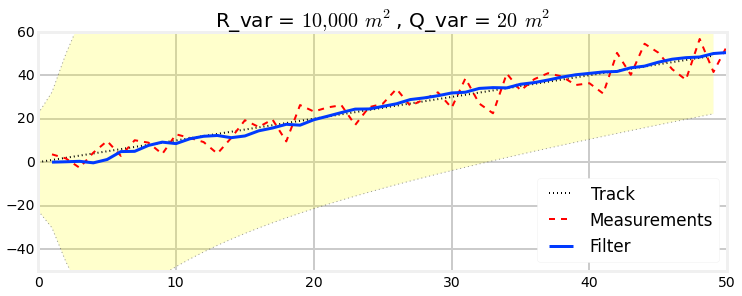

In [45]:
run_filter(data=zs, R=10000, Q=.2, P=P, plot_P=False, 
           title='R_var = $10,000\, m^2$, Q_var = $20\, m^2$');

The effect of this can be subtle. We have created an suboptimal filter because the actual measurement noise variance is 240 $m^2$, not 10,000 $m^2$. By setting the filter's noise variance so high we force the filter to favor the prediction over the measurement. This can lead to apparently very smooth and good looking results. In the chart above the track may look extremely good to you since it follows the ideal path very closely. But, the 'great' behavior at the start should give you pause - the filter has not converged yet ($\mathbf{P}$ is still large) so it should not be able to be so close to the actual position. We can see that $\mathbf{P}$ has not converged because the entire chart is colored with the yellow background denoting the size of $\mathbf{P}$. Let's make $\mathbf{R}$ larger yet. Let's see the result of a bad initial guess for the position by guessing the initial position to be 20 m and the initial velocity to be 1 m/s.

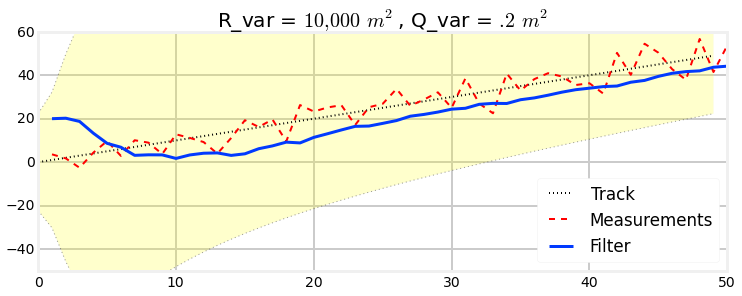

In [46]:
run_filter(data=zs, R=10000, Q=.02, P=P, plot_P=False, 
           initial_x=np.array([20., 1.]),
           title='R_var = $10,000\, m^2$, Q_var = $.2\, m^2$');

Here we can see that the filter cannot acquire the track. This happens because even though the filter is getting reasonably good measurements it assumes that the measurements are bad, and eventually just predicts forward from a bad position at each step. If you think that perhaps that bad initial position would give similar results for a smaller measurement noise, let's set it back to the correct value of 240 $m^2$.

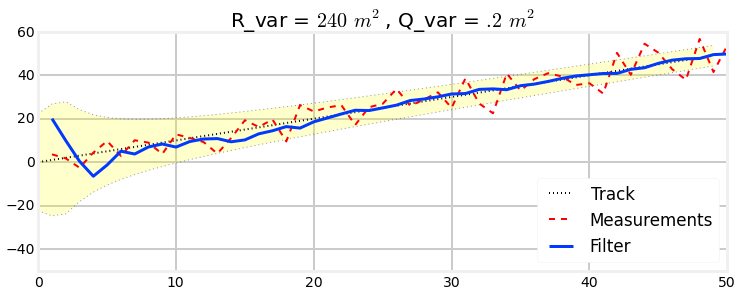

In [47]:
run_filter(data=zs, R=240, Q=.2, P=P, plot_P=False, 
           initial_x=np.array([20., 1.]),
           title='R_var = $240\, m^2$, Q_var = $.2\, m^2$');

Here we see that the filter initially struggles for several iterations to acquire the track, but then it accurately tracks our dog. In fact, this is nearly optimum - we have not designed $\mathbf{Q}$ optimally, but $\mathbf{R}$ is optimal, and thus will yield optimal results. Recall that our rule of thumb for the variance of $\mathbf{Q}$ was to set it between $\frac{1}{2}\Delta a$ to $\Delta a$, where $\Delta a$ is the maximum amount that the acceleration will change between sample period. This only applies for the assumption we are making in this chapter - that acceleration is constant and uncorrelated between each time period. In the Kalman Math chapter we will discuss several different ways of designing $\mathbf{Q}$.

To some extent you can get similar looking output by varying either ${\mathbf{R}}$ or ${\mathbf{Q}}$, but I urge you to not 'magically' alter these until you get output that you like. Always think about the physical implications of these assignments, and vary ${\mathbf{R}}$ and/or ${\mathbf{Q}}$ based on your knowledge of the system you are filtering.

## A Detailed Examination of the Covariance Matrix



So far I have not given a lot of coverage of the covariance matrix $\mathbf{P}$. It is nothing more than the variance of our state - such as the position and velocity of our dog. It has many elements in it, but don't be daunted; we will learn how to interpret a very large $9{\times}9$ covariance matrix, or even larger.

Recall the beginning of the chapter, where we provided the equation for the covariance matrix. It read:

$$
\Sigma = \begin{pmatrix}
  \sigma_1^2 & \sigma_{12} & \cdots & \sigma_{1n} \\
  \sigma_{21} &\sigma_2^2 & \cdots & \sigma_{2n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  \sigma_{n1} & \sigma_{n2} & \cdots & \sigma_n^2
 \end{pmatrix}
$$

(The Kalman filter literature uses $\mathbf{P}$ for $\Sigma$; they both denote the same thing.)

The diagonal contains the variance of each of our state variables. So, if our state variables are

$$\textbf{x}=\begin{bmatrix}x\\\dot{x}\end{bmatrix}$$

and the covariance matrix happens to be

$$\textbf{P}=\begin{bmatrix}2&0\\0&6\end{bmatrix}$$

we know that the variance of $x$ is 2 $m^2$ and the variance of $\dot{x}$ is 6 $(m/s)^2$. The off diagonal elements are all 0, so we also know that $x$ and $\dot{x}$ are not correlated. Recall the ellipses that we drew of the covariance matrices. Let's look at the ellipse for the matrix.

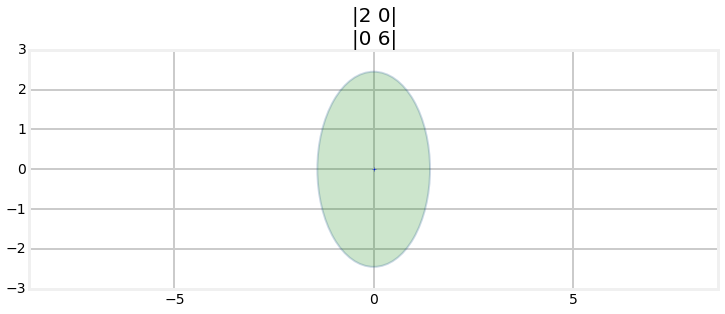

In [48]:
from filterpy.common import stats

P = np.array([[2., 0.], 
              [0., 6.]])
stats.plot_covariance_ellipse((0, 0), P, facecolor='g', alpha=0.2,
                              title='|2 0|\n|0 6|')

Of course it is unlikely that the position and velocity of an object remain uncorrelated for long. Let's look at a more typical covariance matrix

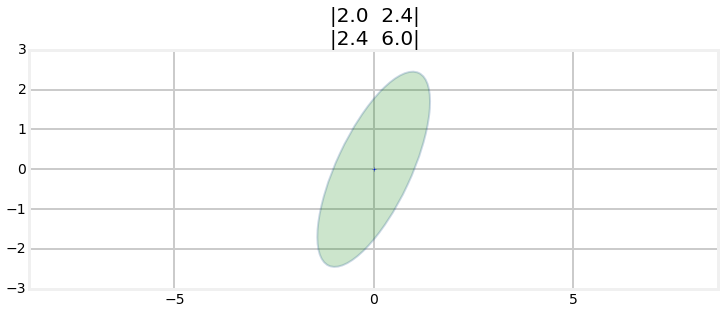

In [49]:
P = np.array([[2.0, 2.4],
              [2.4, 6.0]])
stats.plot_covariance_ellipse((0, 0), P, facecolor='g', alpha=0.2, 
                              title='|2.0  2.4|\n|2.4  6.0|')

Here the ellipse is slanted, signifying that $x$ and $\dot{x}$ are correlated (and, of course, dependent - all correlated variables are dependent). You may or may not have noticed that the off diagonal elements were set to the same value, 2.4. This was not an accident. Let's look at the equation for the covariance for the case where the number of dimensions is two.

$$
\mathbf{P} = \begin{pmatrix}
  \sigma_1^2 & \sigma_{1,2} \\
  \sigma_{2,1} &\sigma_2^2 
 \end{pmatrix}
$$

Here the notation $\sigma_{1,2}$ means the covariance of variables 1 and 2 where that is defined as

$$\sigma_{i,j}
= \mathrm{cov}(X_i, X_j) = \mathrm{E}\begin{bmatrix}
(X_i - \mu_i)(X_j - \mu_j)
\end{bmatrix}$$

We can rearrange the terms to get

$$\begin{aligned}
\sigma_{i,j} &= \mathrm{E}\begin{bmatrix}(X_i - \mu_i)(X_j - \mu_j)\end{bmatrix} \\ 
&= \mathrm{E}\begin{bmatrix} (X_j - \mu_j)(X_i - \mu_i)\end{bmatrix} \\ 
&= \sigma_{j,i}
\end{aligned}$$

In general, we can state that $\sigma_{i,j}=\sigma_{j,i}$.

Let's get back to concrete terms. Let's start by revisiting plotting a track. I will hard code the data and noise to avoid being at the mercy of the random number generator, which might generate data that does not illustrate what I want to talk about. I will start with `P=500`.

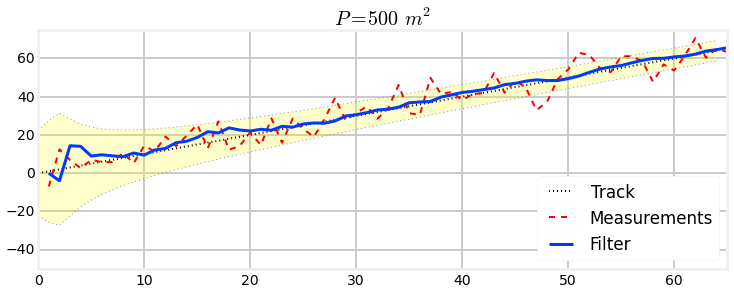

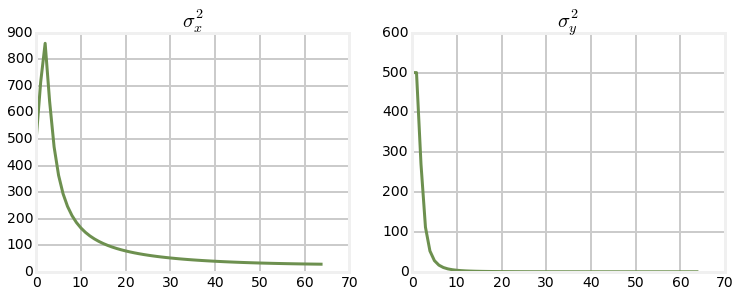

In [50]:
# guarantee the noise is the same each time so I can be sure of
# what the graphs look like.
zs = [-6.947, 12.467, 6.899, 2.643, 6.980, 5.820, 5.788, 10.614, 5.210, 
      14.338, 11.401, 19.138, 14.169, 19.572, 25.471, 13.099, 27.090,
      12.209, 14.274, 21.302, 14.678, 28.655, 15.914, 28.506, 23.181, 
      18.981, 28.197, 39.412, 27.640, 31.465, 34.903, 28.420, 33.889, 
      46.123, 31.355, 30.473, 49.861, 41.310, 42.526, 38.183, 41.383, 
      41.919, 52.372, 42.048, 48.522, 44.681, 32.989, 37.288, 49.141, 
      54.235, 62.974, 61.742, 54.863, 52.831, 61.122, 61.187, 58.441, 
      47.769, 56.855, 53.693, 61.534, 70.665, 60.355, 65.095, 63.386]

var = np.std(zs)**2
run_filter(data=zs, R=var, Q=.2, P=500., plot_P=True, 
           title='$P=500\, m^2$');

Looking at the output we see a very large spike in the filter output at the beginning. If you look at the data (dotted red line) you will see a corresponding, smaller spike in the beginning of the data. We set $P=500\, m^2$, which corresponds to $\text{P}=[\begin{smallmatrix}500&0\\0&500\end{smallmatrix}]$. We now have enough information to understand what this means, and how the Kalman filter treats it. The 500 in the upper left hand corner corresponds to $\sigma^2_x$; therefore we are saying the standard deviation of `x` is $\sqrt{500}$, or roughly 22.36 m. If we recall how standard deviations work, roughly 99% of the samples occur withing $3\sigma$, therefore `P=500` is telling the Kalman filter that the initial estimate could be up to 67 meters off. That is a pretty large error, so when the measurement spikes the Kalman filter distrusts its own estimate and jumps wildly to try to incorporate the measurement. Then, as the filter evolves $\mathbf{P}$ quickly converges to a more realistic value.

Now let us see the effect of a smaller initial value for `P`.

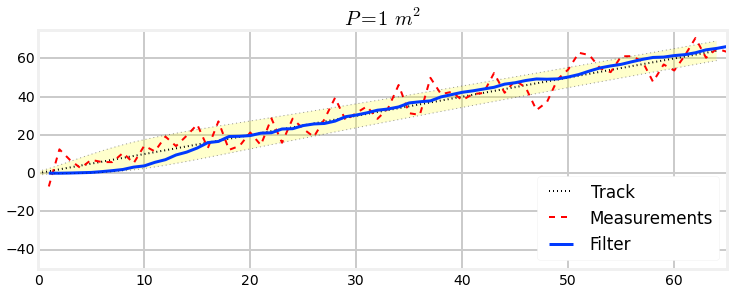

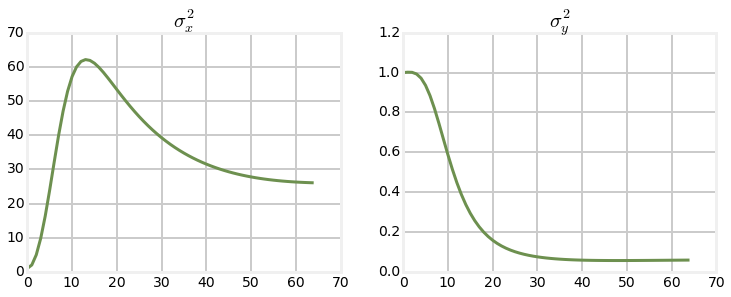

In [51]:
run_filter(data=zs, R=var, Q=.2, P=1., plot_P=True, 
           title='$P=1\, m^2$');

This *looks* good at first blush. The plot does not have the spike that the former plot did; the filter starts tracking the measurements and doesn't take any time to settle to the signal. However, if we look at the plots for P you can see that there is an initial spike for the variance in position, and that it never really converges. Poor design leads to a long convergence time, and suboptimal results. 

So despite the filter tracking very close to the actual signal we cannot conclude that the 'magic' is to just use a small $\text{P}$. Yes, this will avoid having the Kalman filter take time to accurately track the signal, but if we are truly uncertain about the initial measurements this can cause the filter to generate very bad results. If we are tracking a living object we are probably very uncertain about where it is before we start tracking it. On the other hand, if we are filtering the output of a thermometer, we are just as certain about the first measurement as the 1000th. For your Kalman filter to perform well you must set $\text{P}$ to a value that truly reflects your knowledge about the data. 

Let's see the result of a bad initial estimate coupled with a very small $\text{P}$ We will set our initial estimate at 100 m (whereas the dog actually starts at 0m), but set `P=1 m`.

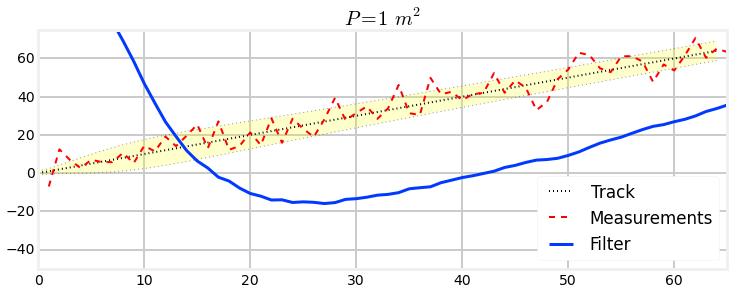

In [52]:
x = np.array([100., 0.]).T

run_filter(data=zs, R=var, Q=.2, P=1., initial_x=x,
           plot_P=False,  title='$P=1\, m^2$');

We can see that the initial estimates are terrible and that it takes the filter a long time to start converging onto the signal . This is because we told the Kalman filter that we strongly believe in our initial estimate of 100 m and were incorrect in that belief.

Now, let's provide a more reasonable value for P and see the difference.

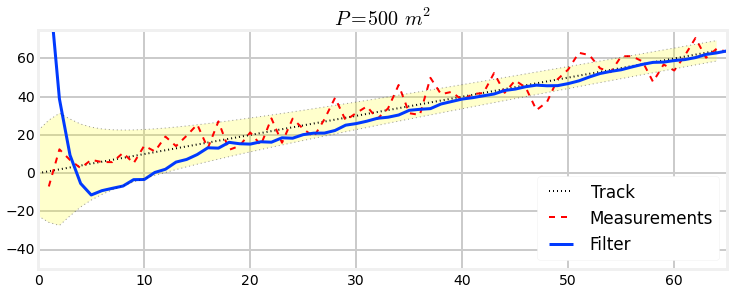

In [53]:
run_filter(data=zs, R=var, Q=.2, P=500., initial_x=x,
           plot_P=False,  title='$P=500\, m^2$');

In this case the Kalman filter is very uncertain about the initial state, so it converges onto the signal much faster. It is producing good output after only 5 to 6 evolutions. With the theory we have developed so far this is about as good as we can do. However, this scenario is a bit artificial; if we do not know where the object is when we start tracking we do not initialize the filter to some arbitrary value, such as 0 m or 100 m. Instead, we would normally take the first measurement, use that to initialize the Kalman filter, and proceed from there. But this is an engineering decision. You really need to understand the domain in which you are working and initialize your filter on the best available information. For example, suppose we were trying to track horses in a horse race. The initial measurements might be very bad, and provide you with a position far from the starting gate. We know that the horse must start at the starting gate; initializing the filter to the initial measurement would lead to suboptimal results. In this scenario we would want to always initialize the Kalman filter with the starting gate position. 

If we have the luxury of not needing to perform the filtering in real time, as the data comes in, we can take advantage of other techniques. We can 'eyeball' the data and see that  the initial measurements are giving us reasonable values for the dog's position because we can see all of the data at once. A *fixed lag smoother* will look N steps ahead before computing the state, and other filters will do things like first run forwards, than backwards over the data. This will be the subject of the Smoothing chapter. It is worthwhile to keep in mind that whenever possible we should prefer this sort of batch processing because it takes advantage of all available information. It does incur cost of additional processing time and increased storage due to the requirement to store some or all of the measurements. And, of course, batch processing does not work if we need real time results, such as when using GPS in our car.

Lets do another Kalman filter for our dog, and this time plot the covariance ellipses on the same plot as the position.

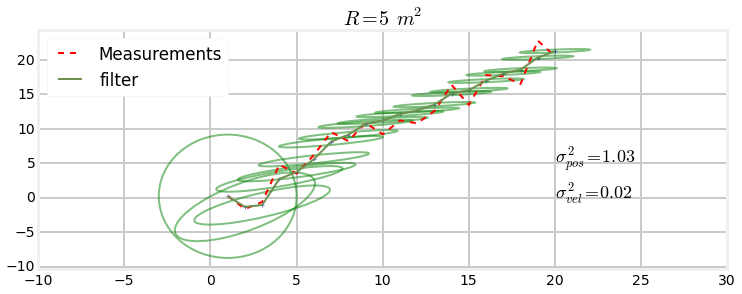

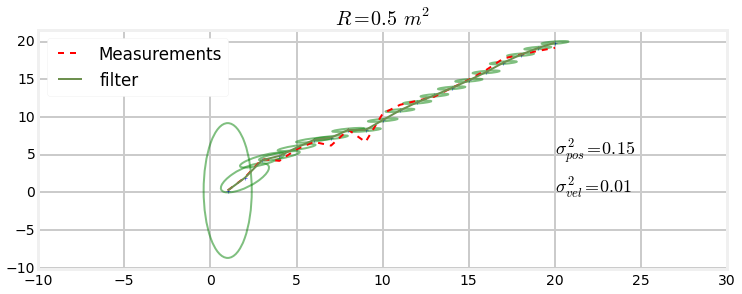

In [64]:
import book_plots as bp
def plot_track_ellipses(noise, count, R, Q=0, P=20., plot_P=True, 
                        title='Kalman Filter'):
    dog = DogSimulation(velocity=1, measurement_variance=noise)
    f = pos_vel_filter(x=(0., 0.), R=R, Q=Q, P=P)

    ps, zs, cov = [], [], []
    for t in range(count):
        z = dog.move_and_sense()
        f.update(z)
        ps.append(f.x[0])
        cov.append(f.P)
        zs.append(z)
        f.predict()

    bp.plot_measurements(range(1,count + 1), zs)
    plt.plot(range(1,count + 1), ps, c='b', lw=2, label='filter')
    plt.legend(loc='best')
    plt.title(title)

    for i,p in enumerate(cov):
        stats.plot_covariance_ellipse(
              (i+1, ps[i]), cov=p, variance=4, axis_equal=False, 
               edgecolor='g', alpha=0.5)

        if i == len(cov)-1:
            s = ('$\sigma^2_{pos} = %.2f$' % p[0,0])
            plt.text (20, 5, s, fontsize=18)
            s = ('$\sigma^2_{vel} = %.2f$' % p[1, 1])
            plt.text (20, 0, s, fontsize=18)
    plt.xlim(-10, 30)
    plt.show()

plot_track_ellipses(noise=5, R=5, Q=.2, count=20, title='$R = 5\, m^2$')
plot_track_ellipses(noise=.5, R=.5, Q=.2, count=20, title='$R = 0.5\, m^2$')

If you are viewing this in IPython Notebook or on the web, here is an animation of the filter filtering the data. I've tuned the filter parameters such that it is easy to see a change in $\mathbf{P}$ as the filter progresses.
<img src='animations/multivariate_track1.gif'>

The output on these is a bit messy, but you should be able to see what is happening. In both plots we are drawing the covariance matrix for each point. We start with the covariance $\mathbf{P}=(\begin{smallmatrix}50&0\\0&50\end{smallmatrix})$, which signifies a lot of uncertainty about our initial belief. After we receive the first measurement the Kalman filter updates this belief, and so the variance is no longer as large. In the top plot the first ellipse (the one on the far left) should be a slightly squashed ellipse. As the filter continues processing the measurements the covariance ellipse quickly shifts shape until it settles down to being a long, narrow ellipse tilted in the direction of movement.

Think about what this means physically. The x-axis of the ellipse denotes our uncertainty in position, and the y-axis our uncertainty in velocity. So, an ellipse that is taller than it is wide signifies that we are more uncertain about the velocity than the position. Conversely, a wide, narrow ellipse shows high uncertainty in position and low uncertainty in velocity. Finally, the amount of tilt shows the amount of correlation between the two variables. 

The first plot, with $R=5 m^2$, finishes up with an ellipse that is wider than it is tall. If that is not clear I have printed out the variances for the last ellipse in the lower right hand corner. The variance for position is 3.85 $m^2$, and the variance for velocity is 3.0 $m^2$. 

In contrast, the second plot, with `R=0.5` $m^2$, has a final ellipse that is taller than wide. The ellipses in the second plot are all much smaller than the ellipses in the first plot. This stands to reason because a small $\small\mathbf{R}$ implies a small amount of noise in our measurements. Small noise means accurate predictions, and thus a strong belief in our position. 

## Question: Explain Ellipse Differences

Why are the ellipses for $\mathbf{R}=5 m^2$ shorter, and more tilted than the ellipses for $\mathbf{R}=0.5 m^2$. Hint: think about this in the context of what these ellipses mean physically, not in terms of the math. If you aren't sure about the answer,change $\mathbf{R}$ to truly large and small numbers such as 100 $m^2$ and 0.1 $m^2$, observe the changes, and think about what this means. 

### Solution

The $x$ axis is for position, and $y$ is velocity. An ellipse that is vertical, or nearly so, says there is no correlation between position and velocity, and an ellipse that is diagonal says that there is a lot of correlation. Phrased that way, it sounds unlikely - either they are correlated or not. But this is a measure of the *output of the filter*, not a description of the actual, physical world. When $\mathbf{R}$ is very large we are telling the filter that there is a lot of noise in the measurements. In that case the Kalman gain $\mathbf{K}$ is set to favor the prediction over the measurement, and the prediction comes from the velocity state variable. So, there is a large correlation between $x$ and $\dot{x}$. Conversely, if $\mathbf{R}$ is small, we are telling the filter that the measurement is very trustworthy, and $\mathbf{K}$ is set to favor the measurement over the prediction. Why would the filter want to use the prediction if the measurement is nearly perfect? If the filter is not using much from the prediction there will be very little correlation reported. 

**This is a critical point to understand!**. The Kalman filter is just a mathematical model for a real world system. A report of little correlation *does not mean* there is no correlation in the physical system, just that there was no *linear* correlation in the mathematical model. It's just a report of how much measurement vs prediction was incorporated into the model.  

Let's bring that point home with a truly large measurement error. We will set $\mathbf{R}=500 m^2$. Think about what the plot will look like before scrolling down. To emphasize the issue, I will set the amount of noise injected into the measurements to 0, so the measurement will exactly equal the actual position. 

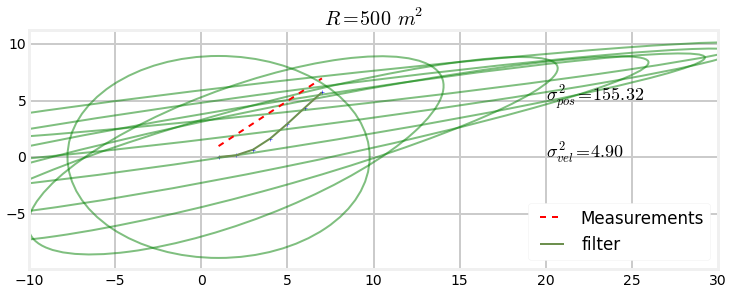

In [65]:
plot_track_ellipses(noise=0., R=500., Q=.2, count=7, title='$R = 500\, m^2$')

I hope the result was what you were expecting. The ellipse quickly became very wide and not very tall. It did this because the Kalman filter mostly used the prediction vs the measurement to produce the filtered result. We can also see how the filter output is slow to acquire the track. The Kalman filter assumes that the measurements are extremely noisy, and so it is very slow to update its estimate for $\dot{x}$. 

Keep looking at these plots until you grasp how to interpret the covariance matrix $\mathbf{P}$. When you start dealing with a, say, $9{\times}9$ matrix it may seem overwhelming - there are 81 numbers to interpret. Just break it down - the diagonal contains the variance for each state variable, and all off diagonal elements are the product of two variances and a scaling factor $p$. You will not be able to plot a $9{\times}9$ matrix on the screen because it would require living in 10-D space, so you have to develop your intuition and understanding in this simple, 2-D case. 

> **sidebar**: when plotting covariance ellipses, make sure to always use *plt.axis('equal')* in your code. If the axis use different scales the ellipses will be drawn distorted. For example, the ellipse may be drawn as being taller than it is wide, but it may actually be wider than tall.

## Understanding the Kalman Prediction


The Kalman filter models a physical system with a multivariate Gaussian $\mathcal{N}(\mathbf{x}, \mathbf{P})$. The equations for the predict step predicts the value of the state at the next time step based on the system model. For a moving object that means we predict the next position based on the current position and velocity. 

Recall what happened to the variance when we performed the predict step in the *Discrete Bayes* chapter and the *Kalman Filter* chapter. Because we are predicting forward in time we lose some certainty about the state. In the *Discrete Bayes* chapter we wrote:

    sigma = sigma + movement sigma

We need to do the same thing except with multivariate Gaussians.


Here are the prediction equations:

$$
\begin{aligned}
\mathbf{x^-} &= \mathbf{F x} + \mathbf{B u} \\
\mathbf{P^-} &= \mathbf{FP{F}}^\mathsf{T} + \mathbf{Q}
\end{aligned}
$$

In general we can model a physical system with a set of differential equations:

$$\dot{\mathbf{x}} = \mathbf{Fx} +\mathbf{Bu}+w$$

where $\mathbf{Fx}$ is the change in the system due to our model of it, $\mathbf{Bu}$ is the change in the system due to any control input, and $w$ is white noise. In this chapter we took advantage of the fact that kinematic systems may be modeled with Newtonian equations which provide an exact answer, but in general this will not be possible. That is a topic for later chapters.

We use linear algebra to implement these equations, storing the mean in $\mathbf{x}$ and the covariance in $\mathbf{P}$. Updating the mean follows directly from the differential equation above:

$$\mathbf{x}^- = \mathbf{F x} + \mathbf{B u}$$

Updating the covariance is a bit harder to understand. I will not prove it here, but we can adjust $\mathbf{P}$ for the loss of knowledge caused by the movement with the computation $\mathbf{FP{F}}^\mathsf{T}$. This is the multivariate equivalent of `sigma + movement_sigma` in the univariate case. Here are the two equations:

$$\begin{aligned}
\sigma &= \sigma + \sigma_{move} \,\,\, &Univariate\\
\mathbf{P^-} &= \mathbf{FP{F}}^\mathsf{T} \,\,\, &Multivariate
\end{aligned}
$$

However, this does not incorporate the process noise $w$. We assume that the process noise is white. This often isn't true, but it makes the math possible, and making this assumption even when it isn't strictly true usually works.

We need to convert $w$ into a covariance matrix so that it can be added to $\mathbf{P}$. We can do this by computing its expected value:  $\mathbf{Q} = E[\mathbf{ww}^\mathsf{T}]$. This is covered in the *Kalman Math* chapter. Once we have $\mathbf{Q}$ it is just added to the covariance matrix, giving use the equation at the top of this section. I show it here along with an example of how we would do it for the univariate case.

$$\begin{aligned}
\sigma &= \sigma + \sigma_{move} &+ &\sigma_{noise}\,\,\, &Univariate\\
\mathbf{P^-} &= \mathbf{FP{F}}^\mathsf{T} &+ &\mathbf{Q}\,\,\, &Multivariate
\end{aligned}
$$

## Understanding the Kalman Update

The update equations look messier than the predict equations, but that is mostly due to the Kalman filter computing the update in **measurement space**. In general measurements are in a different form than the state. For example we might be tracking temperature and the thermocouple gives reading in volts. Or we are tracking position, but the GPS signal gives us distances and time.

The Kalman filter models the measurements as a Gaussian $\mathcal{N}(\mathbf{z}, \mathbf{R})$. This makes sense. If you buy a thermocouple and design a sensor system with it it will be natural to be thinking in volts. The thermocouple will have error in it that you can model with a Gaussian, and your electronic system to read the signal also has noise in it. It is natural to model these in terms of volts, not temperature. 

### Put Covariance in Measurement Space

So the Kalman filter performs the update by converting the covariance matrix $\mathbf{P}$ into measurement space and then adding the measurement covariance to it. This gives us the first update equation:

$$
\textbf{S} = \mathbf{HP^-H}^\mathsf{T} + \mathbf{R}
$$

$\mathbf{H}$ is our measurement function matrix - it converts a state into a measurement. Therefore the product $\mathbf{HP^-H}^\mathsf{T}$ converts $\mathbf{P}$ into measurement space. 

Recall that we used the same construct in the predict equations to alter $\mathbf{P}$ by the state transition matrix: $\mathbf{FPF}^\mathsf{T}$. This is an extremely common manipulation in control and filter theory. The middle term is altered by the outer term. You can think of $\mathbf{ABA}^\mathsf{T}$ as linear algebra that first adjusts $\mathbf{B}$ by the rows of $\mathbf{A}$ with the product $\mathbf{AB}$ and then incorporates the columns of  $\mathbf{A}$ my multiplying the tranpose of $\mathbf{A}$ into it, giving $\mathbf{ABA}^\mathsf{T}$.


### Kalman Gain
Now we have the covariance in measurement space as $\mathbf{S}$, so we can compute the Kalman gain. The equation for that is

$$
\mathbf{K} = \mathbf{P^-H}^\mathsf{T} \mathbf{S}^{-1}
$$

$\mathbf{K}$ is the *Kalman gain* - the ratio that chooses how far along the residual to select between the measurement and prediction in the graph above. We can think of the inverse of a matrix as linear algebra's way of computing  $\frac{1}{x}$. So we can read the equation for $\textbf{K}$ as meaning

$$ \textbf{K} \approx \frac{\textbf{P}\textbf{H}^\mathsf{T}}{\mathbf{S}} $$

$$
\textbf{K} \approx \frac{uncertainty_{prediction}}{uncertainty_{measurement}}\textbf{H}^\mathsf{T}
$$

In other words, the *Kalman gain* equation is doing nothing more than computing a ratio based on how much we trust the prediction vs the measurement. If we are confident in our measurements and unconfident in our predictions $\mathbf{K}$ will favor the measurement, and vice versa. The equation is complicated because we are doing this in multiple dimensions via matrices, but the concept is simple - scale by a ratio.

Without going into the derivation of $\mathbf{K}$, I'll say that this equation is the result of finding a value of $\mathbf{K}$ that optimizes the *mean-square estimation error*. It does this by finding the minimal values for $\mathbf{P}$ along its diagonal. Recall that the diagonal of $\mathbf{P}$ is just the variance for each state variable. So, this equation for $\mathbf{K}$ ensures that the Kalman filter output is optimal. To put this in concrete terms, for our dog tracking problem this means that the estimates for both position and velocity will be optimal in a least squares sense.

### Compute Residual
Now that we have the Kalman gain we can update the state and covariance. Recall this chart.

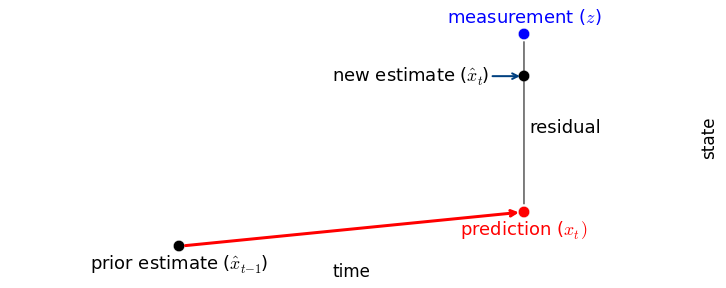

In [56]:
show_residual_chart()

This requires us to subtract the measurement from the prediction and then create the new estimate by scaling it with the Kalman gain. We cannot compute the residual as $\mathbf{z}-\mathbf{x}$ because the units and types of the measurement and state are normally different. The measurement function matrix $\mathbf{H}$ converts the state into measurement space, so the computation for the residual is

$$\mathbf{y} = \mathbf{z} - \mathbf{Hx}$$

### Update State
Now that we have the residual we scale it with the Kalman gain and add it to the state.

$$\mathbf{x} = \mathbf{x} + \mathbf{Ky}$$

This just multiplies the residual by the Kalman gain, and adds it to the state variable. In other words, this is the computation of our new estimate.

### Update Covariance

Finally, we have:

$$\mathbf{P}=(\mathbf{I}-\mathbf{KH})\mathbf{P}\tag{6}$$

$I$ is the identity matrix, and is the way we represent $1$ in multiple dimensions. $H$ is our measurement function, and is a constant.  So, simplified, this is simply $P = (1-cK)P$. $K$ is our ratio of how much prediction vs measurement we use. So, if $K$ is large then $(1-cK)$ is small, and P will be made smaller than it was. If $K$ is small, then $(1-cK)$ is large, and P will be made larger than it was. So we adjust the size of our uncertainty by some factor of the *Kalman gain*.

I would like to draw your attention back to the g-h filter, which included this Python code:

    # update filter 
    w = w * (1-scale_factor) + z * scale_factor

This multidimensional Kalman filter equation is partially implementing this calculation for the covariance instead of the state.

## Batch Processing

The Kalman filter is designed as a recursive algorithm - as new measurements come in we immediately create a new estimate. But it is very common to have a set of data that have been already collected which we want to filter. Kalman filters can always be run in a *batch* mode, where all of the measurements are filtered at once. We have implemented this in `KalmanFilter.batch_filter()`. Internally, all the function does is loop over the measurements and collect the resulting state and covariance estimates in arrays. It simplifies your logic and conveniently gathers all of the outputs into arrays. More importantly, this also allows you to use a smoothing method which generates far better results. I will demonstrate that in the next section. Here I will show you how perform the batch filtering step.

First collect your measurements into an array or list. Maybe it is in a CSV file, for example.

    zs = read_altitude_from_csv()

Or maybe you will generate it using a generator:

    zs = [some_func(i) for i in range(1000)]

Then call the `batch_filter()` method.

    Xs, Ps, Xs_pred, Ps_pred = kfilter.batch_filter(zs)
    
The function takes the list/array of measurements, filters it, and returns a list of state estimates (Xs), covariance matrices (Ps), and the predictions for the same (Xs_pred, Ps_pred).

Here is a complete example.

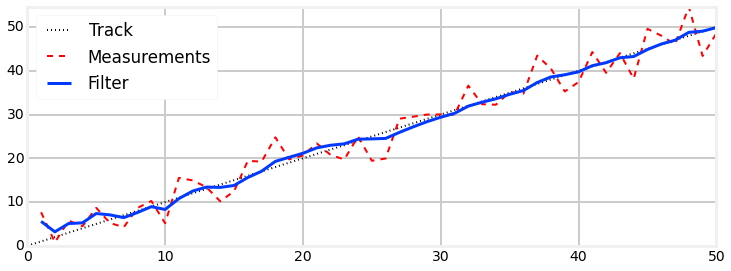

In [57]:
dog = DogSimulation(velocity=1, measurement_variance=10.)
f = pos_vel_filter(x=(0., 0.), R=3., Q=.02, P=P)
count = 50
zs = [dog.move_and_sense() for t in range(count)]
Xs, _, _, _ = f.batch_filter(zs)

bp.plot_track([0, count], [0, count])
bp.plot_measurements(range(1, count + 1), zs)
bp.plot_filter(range(1, count + 1), Xs[:,0])
plt.legend(loc='best')
plt.show()

## Smoothing the Results

I have an entire chapter on using the Kalman filter to smooth data; I will not repeat the chapter's information here. However, it is so easy to use, and offers such a profoundly improved output that I will tease you will a few examples. The smoothing chapter is not especially difficult; you are sufficiently prepared to read it now.

Let's assume that we are tracking a car that has been traveling in a straight line. We get a measurement that implies that the car is starting to turn to the left. The Kalman filter moves the state estimate somewhat towards the measurement, but it cannot judge whether this is just a particularly noisy measurement or the true start of a turn. 

However, if we have future measurements we can decide if a turn was made. Suppose the subsequent measurements all continue turning left. We can then be sure that that a turn was initiated. On the other hand, if the subsequent measurements continued on in a straight line we would know that the measurement was noisy and should be mostly ignored. Instead of making an estimate part way between the measurement and prediction the estimate will either fully incorporate the measurement or ignore it, depending on what the future measurements imply about the object's movement.

FilterPy implements a form of this algorithm which is called an *RTS smoother*, after the three inventors of the algorithm: Rauch, Tung, and Striebel. The routine is `KalmanFilter.rts_smoother()`. To use it pass in the means and covariances computed from the `batch_filter` step, and receive back the smoothed means, covariances, and Kalman gain.

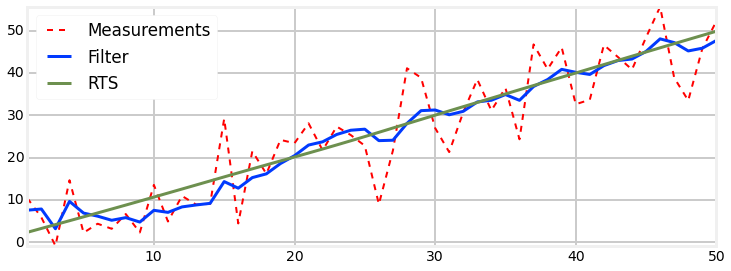

In [58]:
from numpy.random import seed
dog = DogSimulation(velocity=1, measurement_variance=40.)
f = pos_vel_filter(x=(0., 0.), R=3., Q=.2, P=P)
count = 50
seed(8923)
zs = [dog.move_and_sense() for t in range(count)]
xs, Covs, _, _ = f.batch_filter(zs)
Ms, Ps, _ = f.rts_smoother(Xs, Covs)

bp.plot_measurements(range(1, count + 1), zs)
bp.plot_filter(range(1, count + 1), xs[:, 0])
plt.plot(range(1,  count + 1), Ms[:, 0], label='RTS')
plt.legend(loc='best')
plt.show()

This output is fantastic!. Two things are very apparent to me in this chart. First, the RTS output is much, much smoother than the KF output. Second, it is almost always more accurate than the KF output (we will examine this claim in detail in the **Smoothing** chapter).


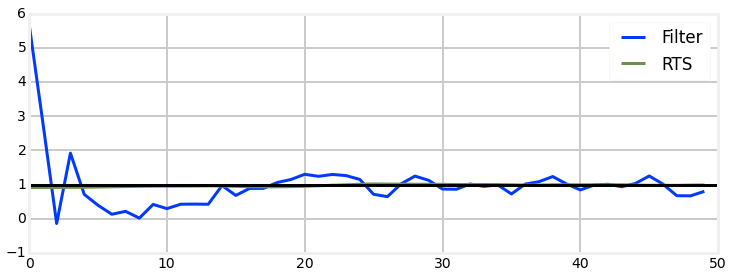

In [59]:
dog = DogSimulation(velocity=1, measurement_variance=40.)
f = pos_vel_filter(x=(0., 0.), R=3., Q=.2, P=P)
count = 50
seed(8923)
zs = [dog.move_and_sense() for t in range(count)]
xs, Covs, _, _ = f.batch_filter(zs)
Ms, Ps, _ = f.rts_smoother(Xs, Covs)
bp.plot_filter(xs[:, 1])
plt.plot(Ms[:, 1], label='RTS')
plt.legend(loc='best')
plt.gca().axhline(1, c='k')
plt.show()

The improvement in the velocity, which is an unobserved variable, is even more dramatic. We will explore why this is so in the next exercise.

## Exercise: Compare Velocities

Since we are plotting velocities let's look at what the the 'raw' velocity is, which we can compute by subtracting subsequent measurements. i.e the velocity at time 1 can be approximated by xs[1] - xs[0]. Plot the raw value against the values estimated by the Kalman filter. Discuss what you see.

In [60]:
# your code here

### Solution

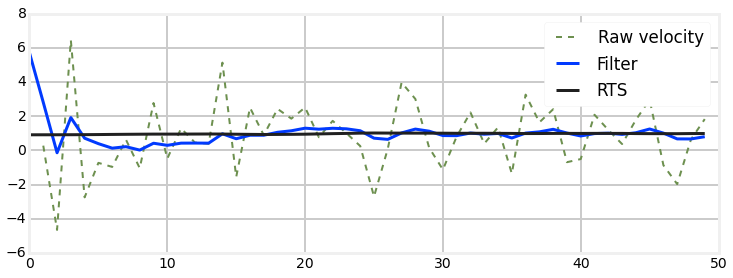

In [61]:
dx = np.diff(xs[:, 0], axis=0)
plt.plot(range(1,count), dx, c='r',ls='--', lw=2, label='Raw velocity')
plt.plot(xs[:, 1], label='Filter')
plt.plot(Ms[:, 1], label='RTS')
plt.legend(loc='best')
plt.show()

We see that the noise swamps the signal, causing the raw values to be essentially worthless. The filter is maintaining a separate estimate for velocity. The Kalman gain $\mathbf{k}$ is multidimensional. For example, it might have the value  $\mathbf{k} = [0.1274, 0.843]^\mathsf{T}$. the first value is used to scale the residual of the position, and the second value will scale the residual of the velocity. The covariance matrix tells the filter how correlated the position and velocity are, and each will be optimally filtered. 

I show this to reiterate the importance of using Kalman filters to compute velocities, accelerations, and even higher order values. I use a Kalman filter even when my measurements are so accurate that I am willing to use them unfiltered because it allows me accurate estimates for velocities and accelerations.

## References

- [1] http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html

- [2] https://en.wikipedia.org/wiki/Kalman_filter

- [3] Brown, Robert Grover. *Introduction to Random Signals and Applied Kalman Filtering* John Wiley & Sons, Inc. 2012

- [4] `FilterPy` library. Roger Labbe.
https://github.com/rlabbe/filterpy